<a href="https://colab.research.google.com/github/NadiaCarvalho/MCM-Latent-Spaces/blob/main/MCM24_Latent_Spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

In [ ]:
# @title Dependencies loading

!pip install pretty_midi -q
!pip install umap-learn -q
!apt install libgraphviz-dev -q
!pip install pygraphviz -q
!pip install networkx==3.2.1 -q
!pip install pypianoroll -q
!pip install plotly -q
!pip install vmo -q

!pip install torch>=2.0.0 -q
!pip install tensorboardX -q
!pip install lightning -q

import torch
print('torch version:', torch.__version__)

Reading package lists...
Building dependency tree...
Reading state information...
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
torch version: 2.1.0+cu121


In [ ]:
# @title Musescore Settings

!apt-get update -q && apt-get install musescore lilypond -q
%env QT_QPA_PLATFORM=offscreen

import music21

env = music21.environment.Environment()
env['lilypondPath'] = '/usr/local/bin/lilypond'

env['pdfPath'] = '/usr/bin/musescore'
env['graphicsPath'] = '/usr/bin/musescore'

env['musicxmlPath'] = '/usr/bin/musescore'
env['musescoreDirectPNGPath'] = '/usr/bin/musescore'
env['autoDownload'] = 'allow'

env['warnings'] = 0

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
lilypond is already the newest version (2.22.1-2).
musescore is already the newest version (2.3.2+dfsg4-15).
0 upgraded, 0 newly installed, 0 to remove and 34

In [ ]:
# @title MODEL definition
### Dependencies
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 25 13:41:24 2020

@author: prang
"""
import random
from typing import Any, Dict, Optional

import lightning as L
import torch  # type: ignore
from lightning.pytorch.utilities.types import STEP_OUTPUT
from torch import nn  # type: ignore
### Encoder
class Encoder_RNN(nn.Module):

    def __init__(self, input_dim, hidden_size, latent_size, num_layers,
                 dropout=0.5, packed_seq=False, device='cpu'):
        """ This initializes the encoder """
        super(Encoder_RNN, self).__init__()

        # Parameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.packed_seq = packed_seq
        self.batch_first = True
        self.device = device

        # Layers
        self.RNN = nn.LSTM(input_dim, hidden_size, batch_first=self.batch_first,
                           num_layers=num_layers, bidirectional=True,
                           dropout=dropout)

    def forward(self, x, h0, c0, batch_size):

        # Pack sequence if needed
        if self.packed_seq:
            x = torch.nn.utils.rnn.pack_padded_sequence(x[0], x[1],
                                                        batch_first=self.batch_first,
                                                        enforce_sorted=False)
        # Forward pass
        _, (h, _) = self.RNN(x, (h0, c0))

        # Be sure to not have NaN values
        assert ((h == h).all()), 'NaN value in the output of the RNN, try to \
                                lower your learning rate'
        h = h.view(self.num_layers, 2, batch_size, -1)
        h = h[-1]
        h = torch.cat([h[0], h[1]], dim=1)

        return h

    def init_hidden(self, batch_size=1):
        # Bidirectional -> num_layers * 2
        return (torch.zeros(self.num_layers * 2, batch_size, self.hidden_size,
                            dtype=torch.float, device=self.device),) * 2
### Decoder
class Decoder_RNN_hierarchical(nn.Module):

    def __init__(self, input_size, latent_size, cond_hidden_size, cond_outdim,
                 dec_hidden_size, num_layers, num_subsequences, seq_length,
                 teacher_forcing_ratio=0, dropout=0.5):
        """ This initializes the decoder """
        super(Decoder_RNN_hierarchical, self).__init__()

        # Parameters
        self.num_subsequences = num_subsequences
        self.input_size = input_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.subseq_size = self.seq_length // self.num_subsequences

        # Layers
        self.tanh = nn.Tanh()
        self.fc_init_cond = nn.Linear(
            latent_size, cond_hidden_size * num_layers)
        self.conductor_RNN = nn.LSTM(latent_size // num_subsequences, cond_hidden_size,
                                     batch_first=True, num_layers=num_layers,
                                     bidirectional=False, dropout=dropout)
        self.conductor_output = nn.Linear(cond_hidden_size, cond_outdim)
        self.fc_init_dec = nn.Linear(cond_outdim, dec_hidden_size * num_layers)
        self.decoder_RNN = nn.LSTM(cond_outdim + input_size, dec_hidden_size,
                                   batch_first=True, num_layers=num_layers,
                                   bidirectional=False, dropout=dropout)
        self.decoder_output = nn.Linear(dec_hidden_size, input_size)

    def forward(self, latent, target, batch_size, teacher_forcing, device):

        # Get the initial state of the conductor
        h0_cond = self.tanh(self.fc_init_cond(latent))
        h0_cond = h0_cond.view(self.num_layers, batch_size, -1).contiguous()
        # Divide the latent code in subsequences
        latent = latent.view(batch_size, self.num_subsequences, -1)
        # Pass through the conductor
        subseq_embeddings, _ = self.conductor_RNN(latent, (h0_cond,)*2)
        subseq_embeddings = self.conductor_output(subseq_embeddings)

        # Get the initial states of the decoder
        h0s_dec = self.tanh(self.fc_init_dec(subseq_embeddings))
        h0s_dec = h0s_dec.view(self.num_layers, batch_size,
                               self.num_subsequences, -1).contiguous()
        # Init the output seq and the first token to 0 tensors
        out = torch.zeros(batch_size, self.seq_length, self.input_size,
                          dtype=torch.float, device=device)
        token = torch.zeros(batch_size, self.subseq_size, self.input_size,
                            dtype=torch.float, device=device)
        # Autoregressivly output tokens
        for sub in range(self.num_subsequences):
            subseq_embedding = subseq_embeddings[:, sub, :].unsqueeze(1)
            subseq_embedding = subseq_embedding.expand(
                -1, self.subseq_size, -1)
            h0_dec = h0s_dec[:, :, sub, :].contiguous()
            c0_dec = h0s_dec[:, :, sub, :].contiguous()
            # Concat the previous token and the current sub embedding as input
            dec_input = torch.cat((token, subseq_embedding), -1)
            # Pass through the decoder
            token, (h0_dec, c0_dec) = self.decoder_RNN(
                dec_input, (h0_dec, c0_dec))
            token = self.decoder_output(token)
            # Fill the out tensor with the token
            out[:, sub*self.subseq_size: ((sub+1)*self.subseq_size), :] = token
            # If teacher_forcing replace the output token by the real one sometimes
            if teacher_forcing:
                if random.random() <= self.teacher_forcing_ratio:
                    token = target[:, sub *
                                   self.subseq_size: ((sub+1)*self.subseq_size), :]
        return out
### VAE
class VAE(nn.Module):

    def __init__(self, encoder, decoder, input_representation, teacher_forcing=True, device='cpu'):
        super(VAE, self).__init__()
        """ This initializes the complete VAE """

        # Parameters
        self.input_rep = input_representation
        self.tf = teacher_forcing
        self.encoder = nn.ModuleList(encoder)
        self.decoder = nn.ModuleList(decoder)
        self.device = device

        # Layers
        self.hidden_to_mu = nn.Linear(
            2 * encoder.hidden_size, encoder.latent_size)
        self.hidden_to_sig = nn.Linear(
            2 * encoder.hidden_size, encoder.latent_size)

    def forward(self, x):

        if self.input_rep == 'notetuple':
            batch_size = x[0].size(0)
        else:
            batch_size = x.size(0)

        # Encoder pass
        h_enc, c_enc = self.encoder.init_hidden(batch_size)  # type: ignore
        hidden = self.encoder(x, h_enc, c_enc, batch_size)
        # Reparametrization
        mu = self.hidden_to_mu(hidden)
        sig = self.hidden_to_sig(hidden)
        eps = torch.randn_like(mu).detach().to(self.device)
        latent = (sig.exp().sqrt() * eps) + mu

        # Decoder pass
        if self.input_rep == 'midilike':
            # One hot encoding of the target for teacher forcing purpose
            target = torch.nn.functional.one_hot(x.squeeze(2).long(),
                                                 self.input_size).float()
            x_reconst = self.decoder(latent, target, batch_size,
                                     teacher_forcing=self.tf, device=self.device)
        else:
            x_reconst = self.decoder(latent, x, batch_size,
                                     teacher_forcing=self.tf, device=self.device)

        return mu, sig, latent, x_reconst

    def batch_pass(self, x, loss_fn, optimizer, w_kl, test=False):

        # Zero grad
        self.zero_grad()

        # Forward pass
        mu, sig, latent, x_reconst = self(x)

        # Compute losses
        kl_div = - 0.5 * torch.sum(1 + sig - mu.pow(2) - sig.exp())
        if self.input_rep in ["midilike", "MVAErep"]:
            reconst_loss = loss_fn(x_reconst.permute(
                0, 2, 1), x.squeeze(2).long())
        elif self.input_rep == "notetuple":
            x_reconst = x_reconst.permute(0, 2, 1)
            x_in, l = x
            loss_ts_maj = loss_fn(
                x_reconst[:, :len(self.vocab[0]), :],  # type: ignore
                x_in[:, :, 0].long())
            current = len(self.vocab[0])  # type: ignore

            loss_ts_min = loss_fn(
                x_reconst[:, current:current +
                          len(self.vocab[1]), :],  # type: ignore
                x_in[:, :, 1].long())
            current += len(self.vocab[1])  # type: ignore

            loss_pitch = loss_fn(
                x_reconst[:, current:current + 129, :], x_in[:, :, 2].long())
            current += 129

            loss_dur_maj = loss_fn(
                x_reconst[:, current:current +
                          len(self.vocab[2]), :],  # type: ignore
                x_in[:, :, 3].long())
            current += len(self.vocab[2])  # type: ignore

            loss_dur_min = loss_fn(
                x_reconst[:, current:current +
                          len(self.vocab[3]), :],  # type: ignore
                x_in[:, :, 4].long())
            reconst_loss = loss_ts_maj + loss_ts_min + \
                loss_pitch + loss_dur_maj + loss_dur_min
        else:
            reconst_loss = loss_fn(x_reconst, x)

        # Backprop and optimize
        if not test:
            loss = reconst_loss + (w_kl * kl_div)
            loss.backward()
            optimizer.step()
        else:
            loss = reconst_loss + kl_div

        return loss, kl_div, reconst_loss

    def generate(self, latent):

        # Create dumb target
        input_shape = (1, self.decoder.seq_length, self.decoder.input_size)
        db_trg = torch.zeros(input_shape)  # type: ignore
        # Forward pass in the decoder
        generated_bar = self.decoder(latent.unsqueeze(0), db_trg, batch_size=1,
                                     device=self.device, teacher_forcing=False)

        return generated_bar
### Lightning VAE
class LightningVAE(L.LightningModule):

    def __init__(self, encoder, decoder, input_representation, vocab=None, teacher_forcing=True):
        super(LightningVAE, self).__init__()
        """ This initializes the complete VAE """
        # Parameters
        self.input_rep = input_representation
        self.tf = teacher_forcing
        self.encoder = encoder
        self.decoder = decoder

        self.w_kl = 0

        self.vocab = vocab
        if input_representation == 'notetuple' and vocab is None:
            raise ValueError(
                'Vocab must be provided for notetuple input representation')

        # Layers
        self.hidden_to_mu = torch.nn.Linear(
            2 * encoder.hidden_size, encoder.latent_size)
        self.hidden_to_sig = torch.nn.Linear(
            2 * encoder.hidden_size, encoder.latent_size)

        if input_representation in ['pianoroll', 'signallike', 'dft128']:
            self.loss_fn = torch.nn.MSELoss(reduction='sum')
        else:
            self.loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

        self.save_hyperparameters(ignore=['encoder', 'decoder'])

    def forward(self, x):

        if self.input_rep == 'notetuple':
            batch_size = x[0].size(0)
        else:
            batch_size = x.size(0)

        # Encoder pass
        h_enc, c_enc = self.encoder.init_hidden(batch_size)
        hidden = self.encoder(x, h_enc, c_enc, batch_size)

        # Reparametrization
        mu = self.hidden_to_mu(hidden)
        sig = self.hidden_to_sig(hidden)
        eps = torch.randn_like(mu).detach().to(self.device)
        latent = (sig.exp().sqrt() * eps) + mu

        # Decoder pass
        if self.input_rep == 'midilike':
            # One hot encoding of the target for teacher forcing purpose
            target = torch.nn.functional.one_hot(x.squeeze(2).long(),
                                                 self.input_size).float()
            x_reconst = self.decoder(latent, target, batch_size,
                                     teacher_forcing=self.tf, device=self.device)
        else:
            x_reconst = self.decoder(latent, x, batch_size,
                                     teacher_forcing=self.tf, device=self.device)

        return mu, sig, latent, x_reconst

    def notetuple_reconstruction_loss(self, x_reconst, x):
        """Compute the reconstruction loss for a
        given input in notetuple format and its reconstruction"""
        x_reconst = x_reconst.permute(0, 2, 1)
        x_in, l = x
        loss_ts_maj = self.loss_fn(
            x_reconst[:, :len(self.vocab[0]), :],  # type: ignore
            x_in[:, :, 0].long())
        current = len(self.vocab[0])  # type: ignore

        loss_ts_min = self.loss_fn(
            x_reconst[:, current:current +
                      len(self.vocab[1]), :],  # type: ignore
            x_in[:, :, 1].long())
        current += len(self.vocab[1])  # type: ignore

        loss_pitch = self.loss_fn(
            x_reconst[:, current:current + 129, :],
            x_in[:, :, 2].long())
        current += 129

        loss_dur_maj = self.loss_fn(
            x_reconst[:, current:current +
                      len(self.vocab[2]), :],  # type: ignore
            x_in[:, :, 3].long())
        current += len(self.vocab[2])  # type: ignore

        loss_dur_min = self.loss_fn(
            x_reconst[:, current:current +
                      len(self.vocab[3]), :],  # type: ignore
            x_in[:, :, 4].long())
        reconst_loss = loss_ts_maj + loss_ts_min + \
            loss_pitch + loss_dur_maj + loss_dur_min

        return reconst_loss

    def compute_reconstruction_loss(self, x, x_reconst):
        """ Compute the reconstruction loss for a given input and its reconstruction """

        if self.input_rep in ["midilike", "MVAErep"]:
            reconst_loss = self.loss_fn(x_reconst.permute(
                0, 2, 1), x.squeeze(2).long())
        elif self.input_rep == "notetuple":
            reconst_loss = self.notetuple_reconstruction_loss(x_reconst, x)
        else:  # pianoroll, signallike, dft128
            reconst_loss = self.loss_fn(x_reconst, x)

        return reconst_loss

    def compute_reconstructions_accuracy(self, reconst_loss, threshold=0.5):
        """ Compute the reconstruction accuracy for a given input and its reconstruction """
        accuracy = (reconst_loss < threshold).float().mean().item() # Calculate accuracy
        return accuracy * 100.0  # Convert to percentage

    def training_step(self, batch, batch_idx):

        x = batch

        # Zero grad
        self.zero_grad()

        # Forward pass
        mu, sig, _, x_reconst = self(x)

        # Compute losses
        kl_div = - 0.5 * torch.sum(1 + sig - mu.pow(2) - sig.exp())
        reconst_loss = self.compute_reconstruction_loss(x, x_reconst)

        # Backprop and optimize
        loss = reconst_loss + (self.w_kl * kl_div)
        self.log("train_loss", loss, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_kl_div", kl_div, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_reconst_loss", reconst_loss, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)

        return {"loss": loss, "kl_div": kl_div, "reconst_loss": reconst_loss}

    def validation_step(self, batch, batch_idx):
        x = batch

        # Zero grad
        self.zero_grad()

        # Forward pass
        mu, sig, _, x_reconst = self(x)

        # Compute losses
        kl_div = - 0.5 * torch.sum(1 + sig - mu.pow(2) - sig.exp())
        reconst_loss = self.compute_reconstruction_loss(x, x_reconst)

        # Backprop and optimize
        loss = reconst_loss + kl_div
        self.log("val_loss", loss, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_kl_div", kl_div, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_reconst_loss", reconst_loss, on_step=True,
                 on_epoch=True, prog_bar=True, sync_dist=True)

        return {"loss": loss, "kl_div": kl_div, "reconst_loss": reconst_loss}

    def generate(self, latent):
        # Create dumb target
        input_shape = (1, self.decoder.seq_length, self.decoder.input_size)
        db_trg = torch.zeros(input_shape)
        # Forward pass in the decoder
        return self.decoder(latent.unsqueeze(0), db_trg, batch_size=1,
                            device=self.device, teacher_forcing=False)

    def interpolate_from_points(self, starting_point, ending_point, nb_points=10):
        # Get the corresponging latent code
        _, _, st_latent, _ = self(starting_point.unsqueeze(0))
        _, _, end_latent, _ = self(ending_point.unsqueeze(0))
        st_latent = st_latent.squeeze(0).detach().numpy()
        end_latent = end_latent.squeeze(0).detach().numpy()
        # Interpolate between this two coordinates
        return torch.tensor(np.linspace(st_latent, end_latent, nb_points))

    def on_test_batch_end(self, outputs: STEP_OUTPUT | None, batch: Any, batch_idx: int, dataloader_idx: int = 0) -> None:
        """Called when the test batch ends."""
        return super().on_test_batch_end(outputs, batch, batch_idx, dataloader_idx)

    def increase_w_kl(self, epoch) -> None:
        """
        Increase the weight of the KL divergence loss
        """
        if self.input_rep in ["pianoroll"]:
            if epoch < 150 and epoch > 0 and epoch % 10 == 0:
                self.w_kl += 1e-5
            elif epoch > 150 and epoch % 10 == 0:
                self.w_kl += 1e-4
        elif self.input_rep in ["midilike", "signallike", "dft128"] and epoch % 10 == 0 and epoch > 0:
            self.w_kl += 1e-8
        elif self.input_rep == "midimono" and epoch % 10 == 0 and epoch > 0:
            self.w_kl += 1e-4
        elif self.input_rep == "notetuple" and epoch % 10 == 0 and epoch > 0:
            self.w_kl += 1e-6

    def on_load_checkpoint(self, checkpoint: Dict[str, Any]) -> None:
        """On load checkpoint callback"""
        super().on_load_checkpoint(checkpoint)

        for i in range(checkpoint['epoch']):
            self.increase_w_kl(i)

        print('Starting with w_kl', self.w_kl)

    def on_train_epoch_end(self) -> None:
        """
        Called when the epoch ends.
        """
        self.increase_w_kl(self.current_epoch)
        self.log("w_kl", self.w_kl, on_step=False,
                 on_epoch=True, prog_bar=True, sync_dist=True)
        return super().on_train_epoch_end()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

# Experiment

## Load Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AdapExperiments
%ls

/content/drive/MyDrive/AdapExperiments
'=2.0.0'                        FirstExperiments/                music.mxl
 audio-dataset/                 latent_c_major_dft128.npy        polydis-v1.pt
 auxiliar/                      latent_c_minor_dft128.npy        results2.xlsx
 chords_c_major_pianoroll.npy  'Latent Space Adaptation.ipynb'   results.xlsx
 chords_c_minor_pianoroll.npy   list_unique.npy                  transition_matrix.npy
 dataset/                       MCM24/
 Figures/                       models/


In [ ]:
#@title LOAD MODEL

def load_model(runname='', encoding='dft128', device='cuda', seq_length=16):

  # Model parameters
  enc_hidden_size = 1024
  cond_hidden_size = 1024
  dec_hidden_size = 1024
  cond_outdim = 512
  num_layers_enc = 2
  num_layers_dec = 2
  num_subsequences = 4
  latent_size = 256

  input_dim = 128
  if encoding == 'dft128':
    input_dim = 130

  output_dim = input_dim

  device = 'cpu'
  if device == 'cuda' and torch.cuda.is_available():  # type: ignore
      device = 'cuda'

  # Instanciate model
  encoder = Encoder_RNN(input_dim, enc_hidden_size,
                          latent_size, num_layers_enc, device=device)
  decoder = Decoder_RNN_hierarchical(output_dim, latent_size, cond_hidden_size,  # type: ignore
                                        cond_outdim, dec_hidden_size=dec_hidden_size, num_layers=num_layers_dec,
                                        num_subsequences=num_subsequences, seq_length=seq_length)  # type: ignore


  model = LightningVAE(encoder, decoder, encoding)

  last_model = f'{runname}/models/last.ckpt'
  last_checkpoint = torch.load(
      last_model, map_location=lambda storage, loc: storage)

  model_weights = last_checkpoint['state_dict']
  for key in list(model_weights):
      model_weights[key.replace("auto_encoder.", "")] = model_weights.pop(key)
  model.load_state_dict(model_weights)

  model.eval()

  return model

## Functions

In [ ]:
import scipy as sp

def dft_reduction(data, normalize=False, return_complex=False, only_dft=False):
    """GET DFT"""
    dft = sp.fft.rfft(data)

    if normalize:
        # GET ENERGY
        energy = dft[0].real
        # REDUCE AND NORMALIZE DFT
        reduced_dft = dft[1: int(len(dft) / 2.0) + 1]
        norm_dft = [df / energy for df in reduced_dft]
        # GET MAGNITUDE
        mag = [abs(CP) for CP in norm_dft]
    else:
        norm_dft = dft
        energy = dft[0].real
        mag = [abs(CP) for CP in norm_dft]

    if return_complex:
        if only_dft:
            return norm_dft
        return norm_dft, energy, mag

    real_dft = []
    for complex_coefficient in norm_dft:
        real_dft.append(complex_coefficient.real)
        real_dft.append(complex_coefficient.imag)

    if only_dft:
        return real_dft
    # RETURN
    return real_dft, energy, mag

import numpy as np

def dft_easy_encoding(x, use_symmetry=True):
  dft_results = np.apply_along_axis(dft_reduction, 1, x, only_dft=True)

  if use_symmetry:
      dft_results = torch.Tensor(dft_results[:, :65*2])
  else:
      dft_results = torch.Tensor(dft_results)

  return dft_results

In [ ]:
def create_chord_from_pitch_classes(pc=[0, 2, 4, 5, 7, 9, 11], fr_size=64, start=60):
  x = np.zeros((fr_size, 128))

  if isinstance(start, list):
    for s in start:
      x[:, [y + s for y in pc if y + s < 128]] = 1
  else:
    x[:, [y + start for y in pc]] = 1
  return x

def create_chord_from_pitches(pitches, fr_size=64):
  x = np.zeros((fr_size, 128))
  x[:, pitches] = 1
  return x

In [ ]:
!pip install fermat

In [ ]:
def get_dist_matrix(latent_space, algorithm='euclidean'):
  import pandas as pd
  from scipy.spatial import distance, distance_matrix

  values = np.asarray([v for v in latent_space.values()])
  dt_m = pd.DataFrame(columns=latent_space.keys(), index=latent_space.keys())

  if algorithm != 'fermat':
    dt_m.iloc[:, :] = distance.cdist(values, values, algorithm)
  else:
    latm = distance_matrix(values, values)

    from fermat import Fermat
    f_exact = Fermat(alpha=3, path_method='FW')
    f_exact.fit(np.asarray(latm))
    dt_m.iloc[:, :] = f_exact.get_distances()

  return dt_m

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

def get_results(m1, m2, verbose=False):
  R2 = r2_score(m1, m2)
  pearson = pearsonr(m1, m2)
  spearman = spearmanr(m1, m2)

  if verbose:
    print('\nR2:', R2, '\nPearson:', pearson, '\nSpearman:', spearman)

  return R2, pearson, spearman

In [ ]:
def get_latent_space(to_visualize, M, model):
  latent_spaces = {}
  for i, ts in enumerate(tqdm.tqdm([c[2] if M == 'dft128' else c[1] for c in to_visualize])):
    if isinstance(ts, np.ndarray):
      ts = torch.tensor(ts, dtype=torch.float32)
    _, _, st_latent, _ = model(ts.unsqueeze(0).to(device))
    latent_spaces[i] = st_latent.squeeze(0).detach().numpy()
  return latent_spaces

def calculate_tiv(pitch_classes):

  pcp = np.zeros(12)
  pcp[pitch_classes] = 1

  dft = dft_reduction(pcp, return_complex=True, only_dft=True)
  dft = dft[1:]/dft[0].real

  tiv = dft * [2, 11, 17, 16, 19, 7]
  return [x for y in zip([i.real for i in tiv], [i.imag for i in tiv]) for x in y]

## Calcular Espaço Voice Leading

def calculate_voice_leading(pitch_classes):
  pcp = np.zeros(12)
  pcp[pitch_classes] = 1

  return pcp

## Run Iterative

In [ ]:
model_p = load_model(f'models/PIANOROLL', 'pianoroll', seq_length=64)
model_d = load_model(f'models/DFT128_V1', 'dft128', seq_length=64)

In [ ]:
fr_size = 64
device = 'cpu'
file = 'results_2.xlsx'

import itertools
import os

import music21 as m21
import numpy as np
import pandas as pd
import tqdm

header = pd.MultiIndex.from_tuples([('choral', '')] + list(itertools.product(['Lat P vs TIV_C', 'Lat D vs TIV_C', 'Lat P vs TIV_E', 'Lat D vs TIV_E', 'Lat P vs TIV_128_C', 'Lat D vs TIV128_C', 'Lat P vs TIV_128_E', 'Lat D vs TIV128_E'], ['R2', 'Pearson', 'Spearman'])) + [('Avg Magnitude P', ''), ('Avg Magnitude D', '')])
results = pd.DataFrame(columns=header)
start = 1

if os.path.exists(file):
  results = pd.read_excel(file, header=[0,1], index_col=0)
  start = results.index[-1] + 2

end = 10
for i, chorale in enumerate(m21.corpus.chorales.Iterator(start, end, returnType='stream')):

  print(f'Chorale {i + start}')

  chorale_c = chorale.chordify(addTies=False)

  to_visualize = []
  for j, chord in enumerate(sorted(list(chorale_c.recurse(classFilter='Chord')), key=lambda x: x.offset)):
    c = create_chord_from_pitches([p.midi for p in chord.pitches], fr_size=fr_size)
    to_visualize.append((j, c, dft_easy_encoding(c), chord))

  tivs_128 = {j: c[2][0].numpy() for j, c in enumerate(tqdm.tqdm(to_visualize))}
  tiv128_matrix = get_dist_matrix(tivs_128, algorithm='cosine')

  tivs = {j: calculate_tiv([p.pitchClass for p in c.pitches]) for j, c in enumerate(tqdm.tqdm([c[3] for c in to_visualize]))}
  tiv_matrix = get_dist_matrix(tivs, algorithm='cosine')

  latent_spaces_p = get_latent_space(to_visualize, 'pianoroll', model_p)
  magnitudes_p = {i: np.linalg.norm(lat) for i, lat in latent_spaces_p.items()}

  latent_spaces_d = get_latent_space(to_visualize, 'dft128', model_d)
  magnitudes_d = {i: np.linalg.norm(lat) for i, lat in latent_spaces_d.items()}

  latp_matrix = get_dist_matrix(latent_spaces_p, algorithm='cosine')
  latp_e_matrix = get_dist_matrix(latent_spaces_p, algorithm='euclidean')
  latd_matrix = get_dist_matrix(latent_spaces_d, algorithm='cosine')
  latd_e_matrix = get_dist_matrix(latent_spaces_d, algorithm='euclidean')

  r2_1, pearson_1, spearman_1 = get_results(latp_matrix.values.ravel(), tiv_matrix.values.ravel())
  r2_2, pearson_2, spearman_2 = get_results(latd_matrix.values.ravel(), tiv_matrix.values.ravel())
  r2_3, pearson_3, spearman_3 = get_results(latp_e_matrix.values.ravel(), tiv_matrix.values.ravel())
  r2_4, pearson_4, spearman_4 = get_results(latd_e_matrix.values.ravel(), tiv_matrix.values.ravel())
  r2_5, pearson_5, spearman_5 = get_results(latp_matrix.values.ravel(), tiv128_matrix.values.ravel())
  r2_6, pearson_6, spearman_6 = get_results(latd_matrix.values.ravel(), tiv128_matrix.values.ravel())
  r2_7, pearson_7, spearman_7 = get_results(latp_e_matrix.values.ravel(), tiv128_matrix.values.ravel())
  r2_8, pearson_8, spearman_8 = get_results(latd_e_matrix.values.ravel(), tiv128_matrix.values.ravel())

  results.loc[len(results.index), :] = [chorale.metadata.title,
                                       r2_1, pearson_1, spearman_1,
                                       r2_2, pearson_2, spearman_2,
                                       r2_3, pearson_3, spearman_3,
                                       r2_4, pearson_4, spearman_4,
                                       r2_5, pearson_5, spearman_5,
                                       r2_6, pearson_6, spearman_6,
                                       r2_7, pearson_7, spearman_7,
                                       r2_8, pearson_8, spearman_8,
                                       np.average(np.asarray(list(magnitudes_p.values()))),
                                       np.average(np.asarray(list(magnitudes_d.values())))]
  results = results.astype(results.dtypes)

  if i % 10 == 0:
    results.to_excel(file)

results.to_excel(file)
results

Chorale 1


100%|██████████| 80/80 [00:58<00:00,  1.36it/s]


Chorale 2


100%|██████████| 79/79 [00:59<00:00,  1.33it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Chorale 3


100%|██████████| 64/64 [00:45<00:00,  1.39it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Chorale 4


100%|██████████| 61/61 [00:45<00:00,  1.35it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Chorale 5


100%|██████████| 123/123 [01:37<00:00,  1.27it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Chorale 6


100%|██████████| 41/41 [00:30<00:00,  1.35it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Chorale 7


100%|██████████| 111/111 [01:22<00:00,  1.35it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Chorale 8


100%|██████████| 124/124 [01:30<00:00,  1.36it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Chorale 9


100%|██████████| 86/86 [01:02<00:00,  1.38it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Chorale 10


100%|██████████| 57/57 [00:48<00:00,  1.18it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


choral Lat P vs TIV_C  \
                                                   R2   
0            Aus meines Herzens Grunde      -0.071471   
1          Ich dank’ dir, lieber Herre       0.168458   
2    Ach Gott, vom Himmel sieh’ darein       0.114518   
3       Es ist das Heil uns kommen her       0.059396   
4             An Wasserflüssen Babylon       0.076462   
5         Christus, der ist mein Leben        0.23818   
6    Nun lob’, mein’ Seel’, den Herren       0.097493   
7       Freuet euch, ihr Christen alle       0.359377   
8  Ermuntre dich, mein schwacher Geist       0.134298   
9    Aus tiefer Not schrei’ ich zu dir       0.194798   

                                                  \
                                         Pearson   
0                      (0.5830022767957467, 0.0)   
1                      (0.6481260834553884, 0.0)   
2                      (0.6190072011607595, 0.0)   
3                      (0.6278733700885772, 0.0)   
4                      (0.5963617076733168, 0.0)   
5  (0.6038937389983978, 1.3055040969608054e-167)   
6                      (0.6332268769874327, 0.0)   
7                      (0.6928997036513751, 0.0)   
8                      (0.6054060723471927, 0.0)   
9                      (0.6842136451030757, 0.0)   

                                                 Lat D vs TIV_C  \
                                        Spearman             R2   
0                      (0.6347257845724518, 0.0)      -0.279858   
1                      (0.6493525798878286, 0.0)      -0.107428   
2                      (0.6007418041369964, 0.0)       0.152582   
3                      (0.6196323896979462, 0.0)      -0.145373   
4                      (0.6039597986890055, 0.0)      -0.063293   
5  (0.6401624329979523, 1.7045747182483163e-194)      -0.006259   
6                      (0.6309535455460545, 0.0)      -0.182457   
7                      (0.6867926680043777, 0.0)      -0.032735   
8                      (0.6074266177239935, 0.0)      -0.142686   
9                      (0.6811260956275582, 0.0)       0.053038   

                                                  \
                                         Pearson   
0                      (0.5702572185208624, 0.0)   
1                      (0.6184250512148242, 0.0)   
2                      (0.6727087233095724, 0.0)   
3                      (0.6120002075708647, 0.0)   
4                      (0.6087905803287266, 0.0)   
5  (0.6353423747587533, 1.0307793337965535e-190)   
6                      (0.5802015189847192, 0.0)   
7                      (0.5912659355341451, 0.0)   
8                      (0.5729297834331282, 0.0)   
9                      (0.6569947457205232, 0.0)   

                                                Lat P vs TIV_E  \
                                       Spearman             R2   
0                     (0.5527018024515896, 0.0)      -6.756087   
1                      (0.611860875025245, 0.0)      -9.241813   
2                     (0.6225531841141776, 0.0)      -7.796315   
3                     (0.5952253256656261, 0.0)      -8.261962   
4                     (0.5961737480887865, 0.0)      -8.135915   
5  (0.6031009977094715, 4.624211938259362e-167)       -6.37801   
6                     (0.5601800517740049, 0.0)      -9.026683   
7                     (0.5556870156939763, 0.0)       -7.46235   
8                     (0.5568925294302104, 0.0)      -7.455831   
9                     (0.6194533504186498, 0.0)      -8.974203   

                                                 \
                                        Pearson   
0                     (0.6426487662535141, 0.0)   
1                     (0.5839221552694172, 0.0)   
2                       (0.59091069260987, 0.0)   
3                     (0.6373440463647713, 0.0)   
4                     (0.5426991166186259, 0.0)   
5  (0.6235728980434093, 9.316017121848193e-182)   
6                      (0.546472268637406, 0.0)   
7                     (0.628156180558981

## Analysis of Results

In [ ]:
ID = "1eG69O3yi-J1MypD-Gl0uBz7NYlPqYZfB" # cossenos
#ID = "1ppJdeFBvAPzuPmv4n8rqDCfuVexLdpUL" # euclidean
ID2 = "1Ptb4YBl7tJ01nSbqcFR6XhcGEYy0g-p2" # tiv-128
!wget "https://docs.google.com/spreadsheets/d/{ID}/export?" -O results.xlsx
!wget "https://docs.google.com/spreadsheets/d/{ID2}/export?" -O results2.xlsx

--2024-02-09 21:02:08--  https://docs.google.com/spreadsheets/d/1eG69O3yi-J1MypD-Gl0uBz7NYlPqYZfB/export?
Resolving docs.google.com (docs.google.com)... 173.194.69.100, 173.194.69.102, 173.194.69.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.69.100|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-10-20-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/aqjg5pptpe5urpe4a3m4jmses0/1707512530000/111793044663653929883/*/1eG69O3yi-J1MypD-Gl0uBz7NYlPqYZfB [following]
--2024-02-09 21:02:10--  https://doc-10-20-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/aqjg5pptpe5urpe4a3m4jmses0/1707512530000/111793044663653929883/*/1eG69O3yi-J1MypD-Gl0uBz7NYlPqYZfB
Resolving doc-10-20-sheets.googleusercontent.com (doc-10-20-sheets.googleusercontent.com)... 74.125.128.132, 2a00:1450:4013:c02::84
Connecting to doc-10-20-sheets.googleusercontent.com (doc-10-20-sheets.googleusercontent.com)|74.125.128.132|:4

In [ ]:
import pandas as pd

def get_tuple_statistic_pvalue(x):
  if isinstance(x, str):
    value = float(x.split('=')[1].split(',')[0])
    pvalue = float(x.split('=')[2][:-1])
  else:
    return (x,)
  return (value, pvalue)

results = pd.read_excel('results.xlsx', header=[0,1], index_col=0)

to_analysis = 'Spearman'
tiv_pcp = 'TIV'

results[(f'Lat P vs {tiv_pcp}', to_analysis)] = results[(f'Lat P vs {tiv_pcp}', to_analysis)].apply(lambda x: get_tuple_statistic_pvalue(x))
results[(f'Lat D vs {tiv_pcp}', to_analysis)] = results[(f'Lat D vs {tiv_pcp}', to_analysis)].apply(lambda x: get_tuple_statistic_pvalue(x))


results[(f'Lat P vs {tiv_pcp}', to_analysis + '_val')] = results[(f'Lat P vs {tiv_pcp}', to_analysis)].apply(lambda x: x[0])
results[(f'Lat D vs {tiv_pcp}', to_analysis + '_val')] = results[(f'Lat D vs {tiv_pcp}', to_analysis)].apply(lambda x: x[0])

print(results[(f'Lat P vs {tiv_pcp}', to_analysis + '_val')].describe())
print(results[(f'Lat D vs {tiv_pcp}', to_analysis + '_val')].describe())


count    371.000000
mean       0.653804
std        0.046112
min        0.491926
25%        0.621943
50%        0.652758
75%        0.681938
max        0.785210
Name: (Lat P vs TIV, Spearman_val), dtype: float64
count    371.000000
mean       0.593698
std        0.055559
min        0.446270
25%        0.555795
50%        0.588039
75%        0.625901
max        0.754447
Name: (Lat D vs TIV, Spearman_val), dtype: float64


In [ ]:
results[(f'Lat P vs TIV', 'Spearman_val')].sort_values(ascending=False)

147    0.785210
139    0.771161
158    0.760912
165    0.758081
259    0.756309
         ...   
224    0.555196
283    0.544163
264    0.539789
330    0.527514
338    0.491926
Name: (Lat P vs TIV, Spearman_val), Length: 371, dtype: float64

In [ ]:
results2 = pd.read_excel('results2.xlsx', header=[0,1], index_col=0)

tiv_pcp2 = 'TIV_128_C'
results2[(f'Lat P vs {tiv_pcp2}', to_analysis)] = results2[(f'Lat P vs {tiv_pcp2}', to_analysis)].apply(lambda x: get_tuple_statistic_pvalue(x))
results2[(f'Lat P vs {tiv_pcp2}', to_analysis + '_val')] = results2[(f'Lat P vs {tiv_pcp2}', to_analysis)].apply(lambda x: x[0])

In [ ]:
df = abs(results[(f'Lat P vs TIV', 'Spearman_val')] - results2[(f'Lat P vs TIV_128_C', 'Spearman_val')])
df.sort_values(ascending=False)

363    0.140298
246    0.128310
294    0.124918
235    0.124505
139    0.120845
         ...   
290    0.000224
277    0.000195
58     0.000126
324    0.000096
43     0.000041
Length: 371, dtype: float64

## Visualization Functions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def get_visualization(algorithm, latent_spaces, n_components=2):
  if algorithm == 'pca':
      from sklearn.decomposition import PCA
      from sklearn.preprocessing import StandardScaler
      pca = PCA(n_components=n_components)
      predictions = pca.fit_transform(
      StandardScaler().fit_transform(latent_spaces))
  elif algorithm == 'tsne':
      from sklearn.manifold import TSNE
      tsne = TSNE(n_components=n_components, perplexity=30 if len(latent_spaces) > 30 else len(latent_spaces)-1)
      predictions = tsne.fit_transform(np.asarray(latent_spaces))
  elif algorithm == 'mds':
      from sklearn.manifold import MDS
      mds = MDS(n_components=n_components)
      predictions = mds.fit_transform(latent_spaces)
  elif algorithm == 'isomap':
      from sklearn.manifold import Isomap
      iso = Isomap(n_components=n_components)
      predictions = iso.fit_transform(latent_spaces)
  elif algorithm == 'lle':
      from sklearn.manifold import LocallyLinearEmbedding
      lle = LocallyLinearEmbedding(n_components=n_components)
      predictions = lle.fit_transform(latent_spaces)
  else:
      import umap.umap_ as umap
      reducer = umap.UMAP(n_components=n_components)
      predictions = reducer.fit_transform(latent_spaces)
  return predictions

import numpy as np

def print_visualization_2d(predictions, labels, algorithm, major=True, title=None):
  fig = plt.figure()
  ax = fig.add_subplot(111)

  if major:
    cl = list(mcolors.TABLEAU_COLORS) + random.sample(list(mcolors.CSS4_COLORS), 10)
    colors = {l:cl[i]  for i, l in enumerate(list(set(labels)))}
    pred_colors = [colors[l] for l in labels]

    _ = ax.scatter(predictions[:,0], predictions[:,1], c=pred_colors, alpha=0.7)
    plt.legend([plt.Line2D([0], [0], marker='o', color='w', label=l, markerfacecolor=colors[l],
                           markersize=10) for l in list(set(labels))], list(set(labels)), loc=(1.04, 0.5))
  else:
    _ = ax.scatter(predictions[:,0], predictions[:,1], alpha=0.7)
    _ = [ax.annotate(label, (predictions[i,0], predictions[i,1])) for i, label in enumerate(labels)]

  if title is None:
    title = "2D Visualization of the latent space using " + algorithm.upper()

  plt.title(title)
  plt.show()
  #plt.savefig('Figures/' + '-'.join(title.split(', ')) + '.png')

## Run Visualizations

In [ ]:
# @title Load Correct Model
M = "pianoroll" # @param ["pianoroll", "dft128"]
model = load_model(f'models/{"PIANOROLL" if M == "pianoroll" else "DFT128_V1"}', M, seq_length=64)

### Run Choral

In [ ]:
CHORAL_NUMBER = 264 # @param {type:"slider", min:1, max:370, step:1}
fr_size = 64 # @param {type:"slider", min:1, max:64, step:1}
import tqdm
import music21 as m21

device = 'cpu'

chorale_1 = m21.corpus.chorales.Iterator(returnType='stream')[CHORAL_NUMBER]
chorale_c = chorale_1.chordify(addTies=False)

to_visualize = []

for i, chord in enumerate(chorale_c.recurse(classFilter='Chord')):
  c = create_chord_from_pitches([p.midi for p in chord.pitches], fr_size=fr_size)
  to_visualize.append((i, c, dft_easy_encoding(c), chord))

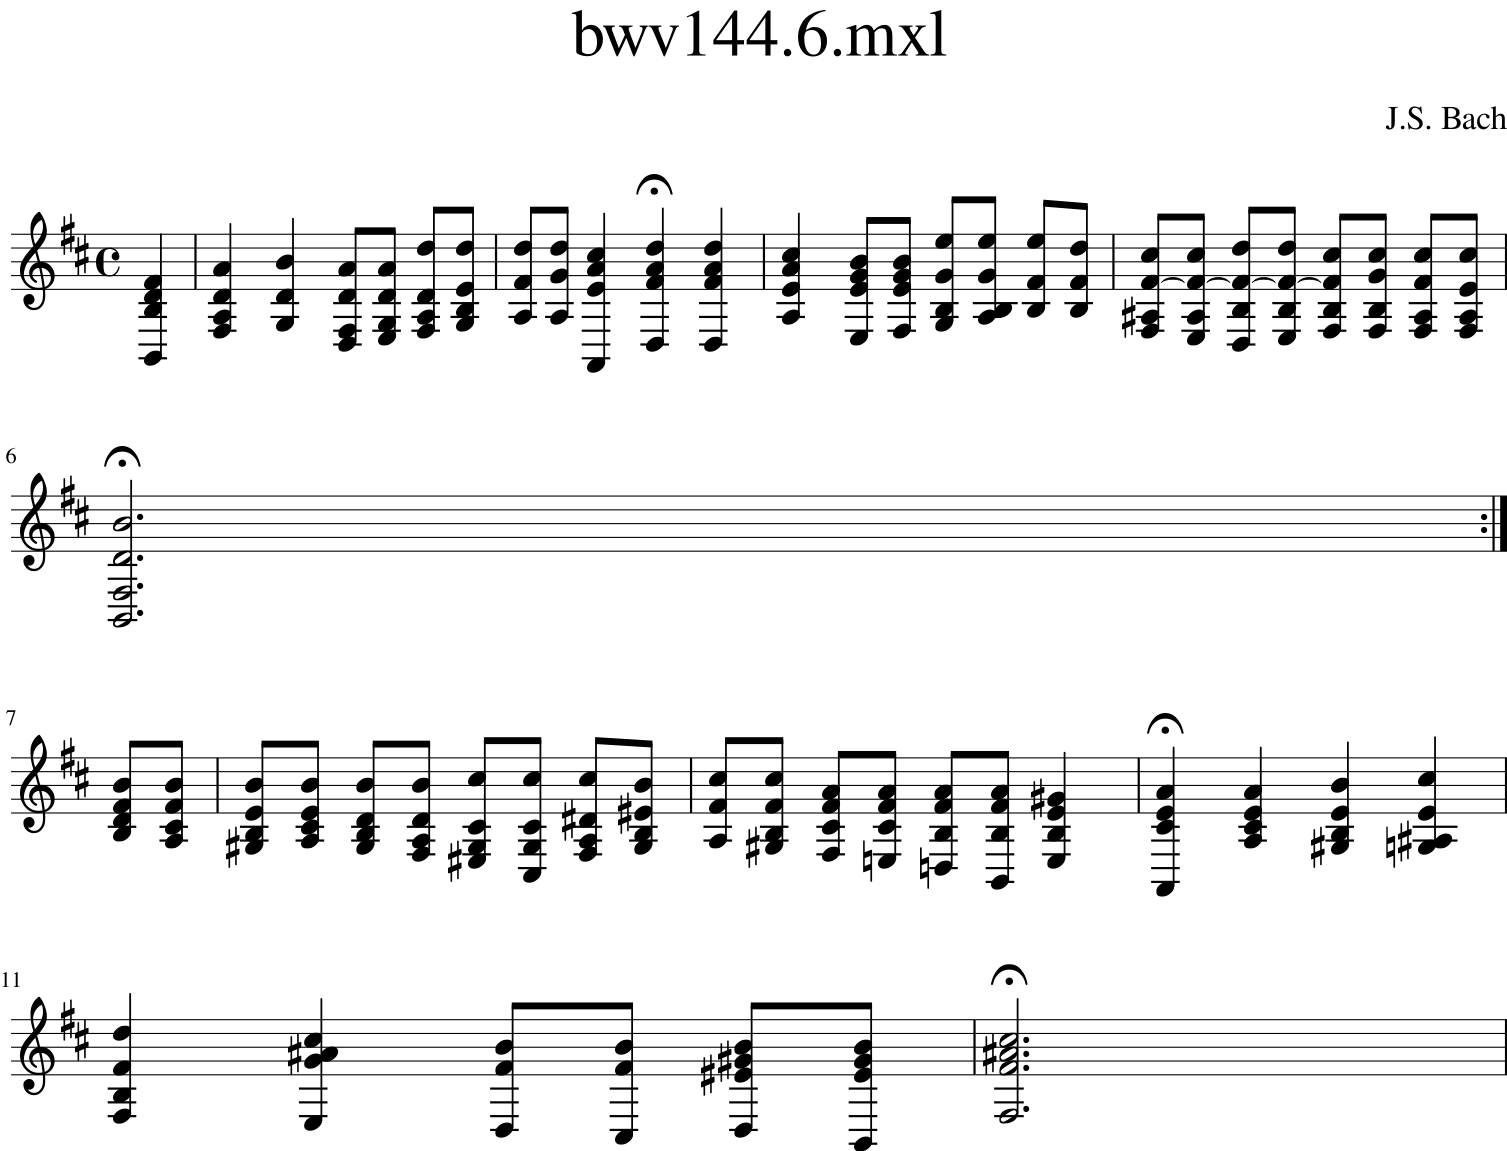

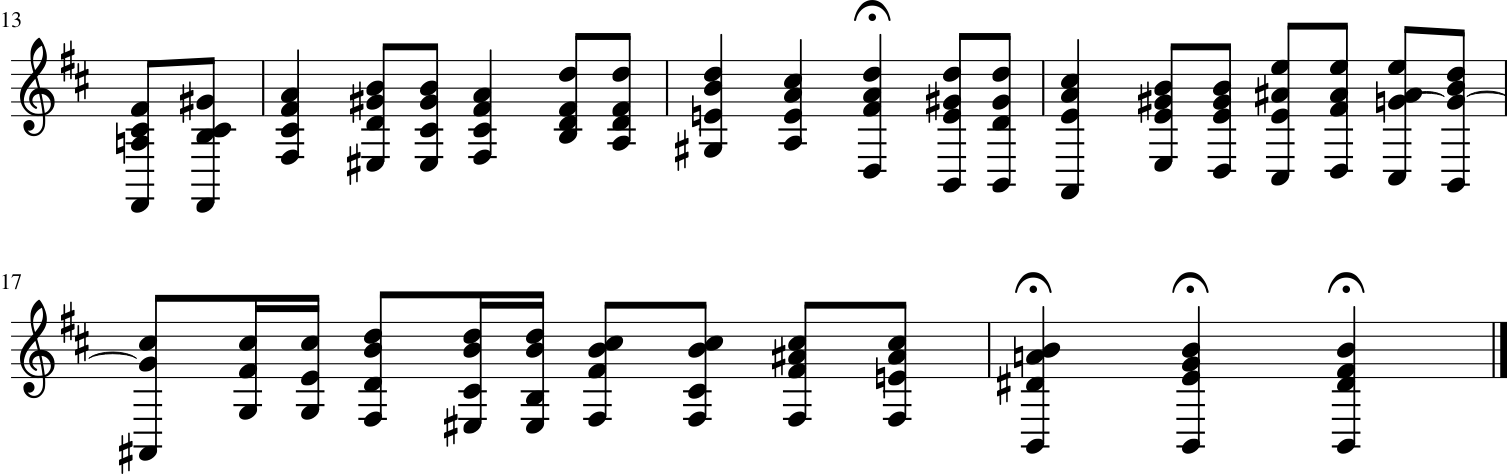

In [ ]:
chorale_c.show()

<ipython-input-76-1a6618d3caab>:1: StreamIteratorInefficientWarning: show is not defined on StreamIterators. Call .stream() first for efficiency
  chorale_c.recurse(classFilter='Chord').show()


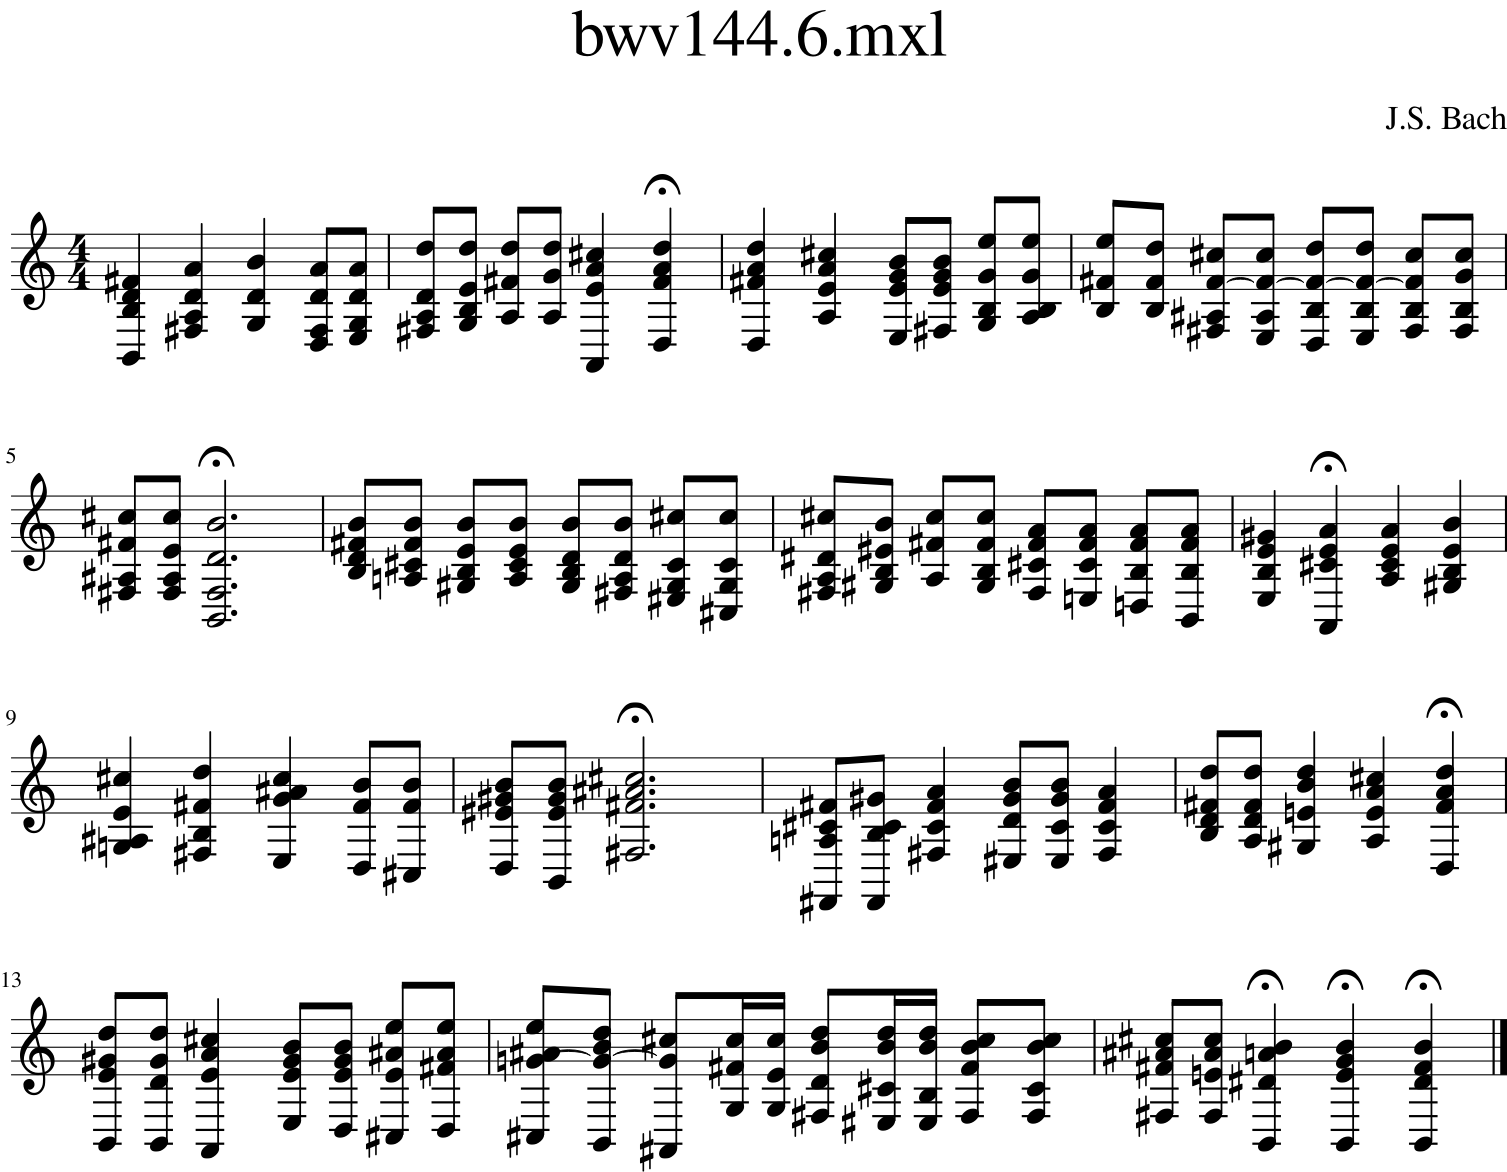

In [ ]:
chorale_c.recurse(classFilter='Chord').show()

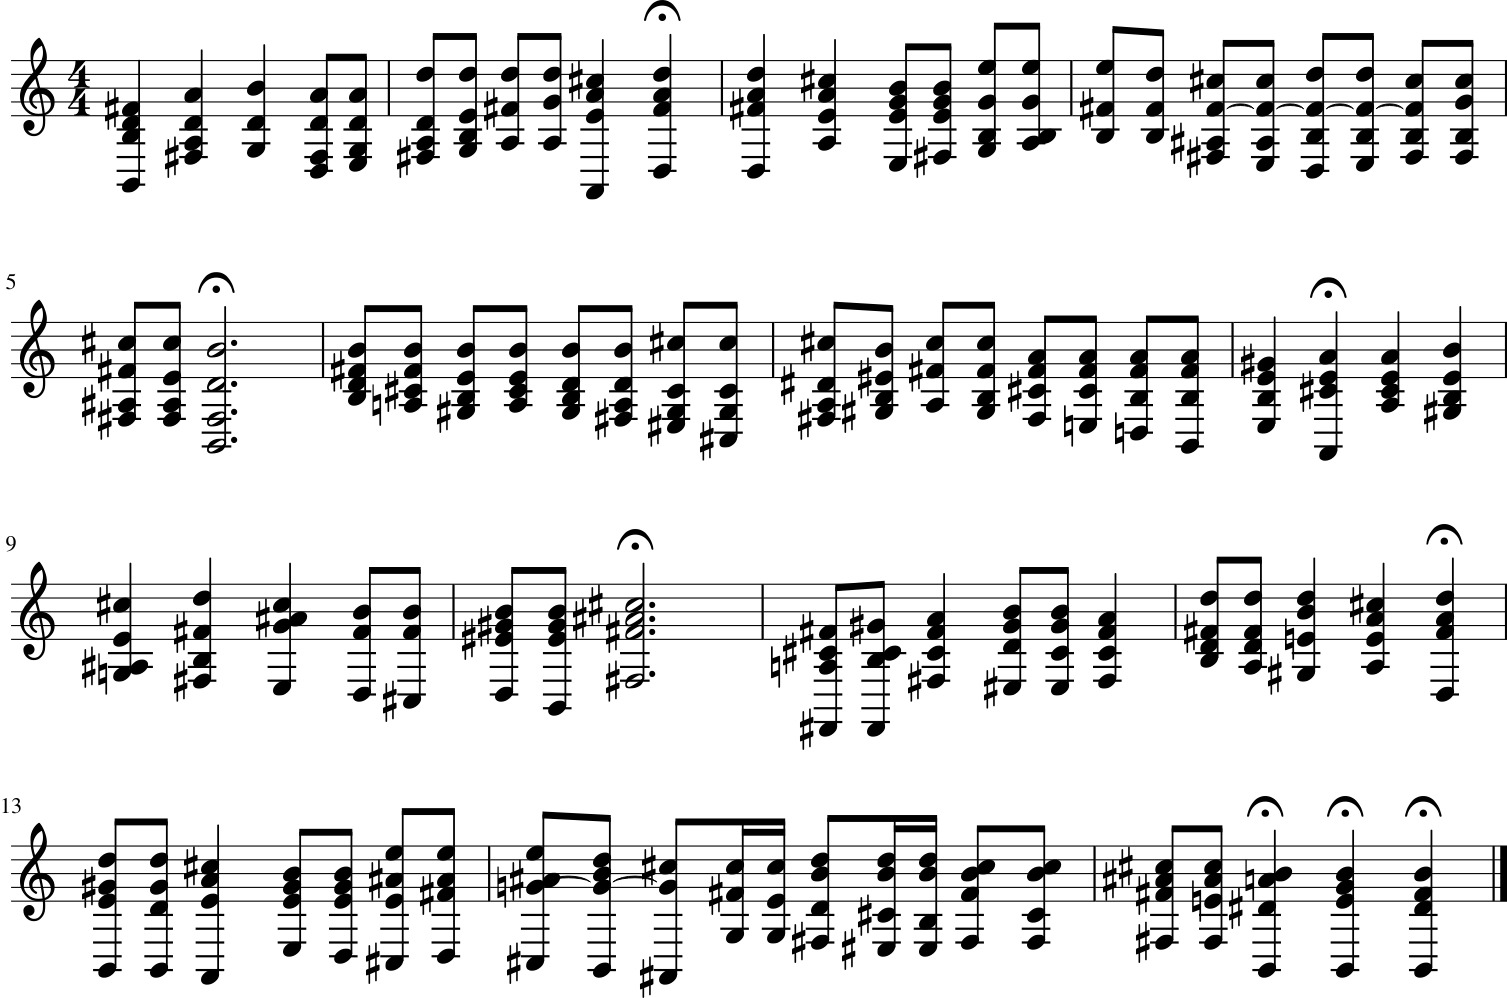

In [ ]:
m21.stream.Part([x[3] for x in to_visualize]).show()

In [ ]:
latent_spaces = get_latent_space(to_visualize, M, model)
#get_dist_matrix(latent_spaces, 'cosine')

100%|██████████| 89/89 [01:26<00:00,  1.03it/s]


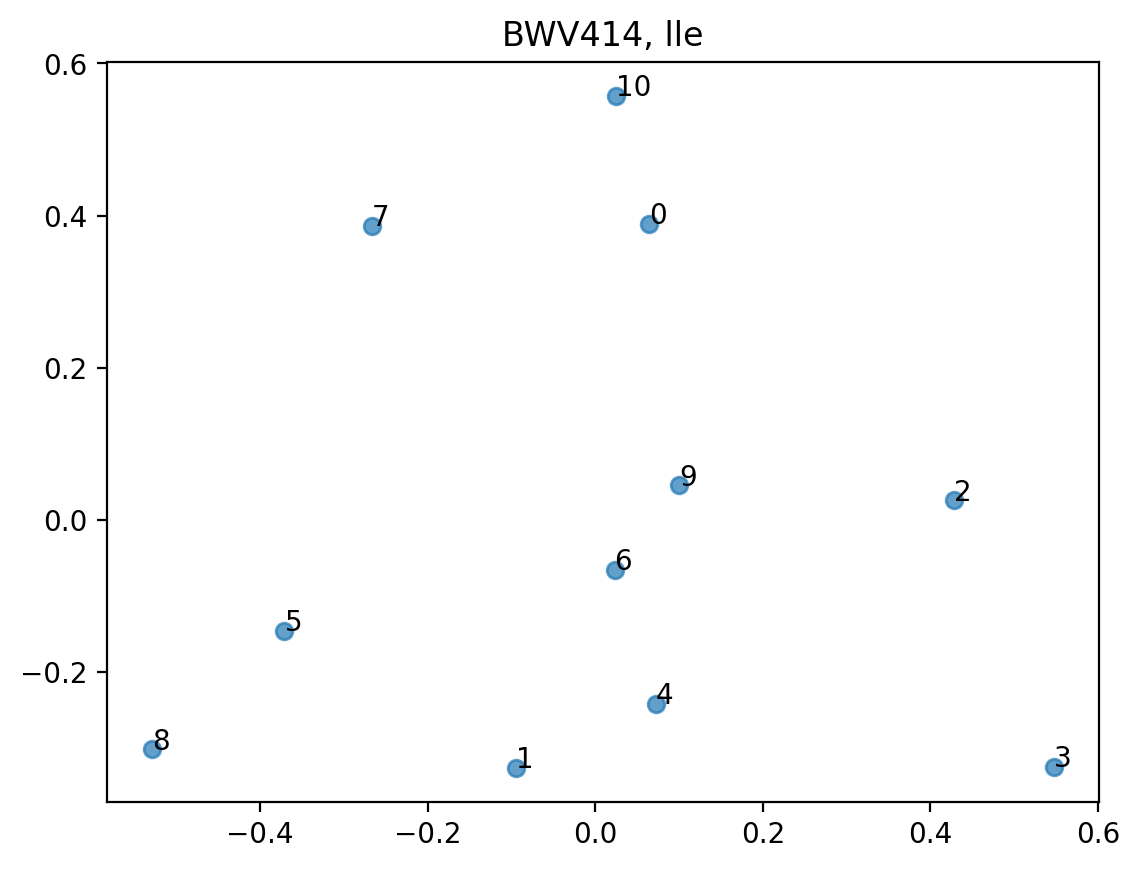

,0,1
0,0.063789,0.389294
1,-0.094960,-0.325908
2,0.428494,0.025961
3,0.547156,-0.324219
4,0.072072,-0.241332
5,-0.370659,-0.145751
6,0.023079,-0.065405
7,-0.265934,0.386286
8,-0.528601,-0.301512
9,0.100124,0.045367


In [ ]:
algorithm = "lle" # @param ["lle", "mds", "pca", "tsne", "isomap", "umap"]
start = 0 # @param {type:"slider", min:0, max:100, step:1}
number_events = 11 # @param {type:"slider", min:0, max:100, step:1}
#labels = [','.join([str(int(p.ps)) for p in c[3].pitches]) for c in to_visualize[start:start+number_events]]
labels = [x[0]-start for x in to_visualize[start:start+number_events]]
points = get_visualization(algorithm, list(latent_spaces.values())[start:start+number_events])
print_visualization_2d(points, labels, algorithm, major=False, title="BWV414" + f', {algorithm}')

import pandas as pd
pd.DataFrame(points)

In [ ]:
tivs = {j: calculate_tiv([p.pitchClass for p in c0.pitches]) for j, c0 in enumerate(tqdm.tqdm([c[3] for c in to_visualize]))}
tivs_128 = {j: c[2][0].numpy() for j, c in enumerate(tqdm.tqdm(to_visualize))}

100%|██████████| 89/89 [00:00<00:00, 52539.49it/s]


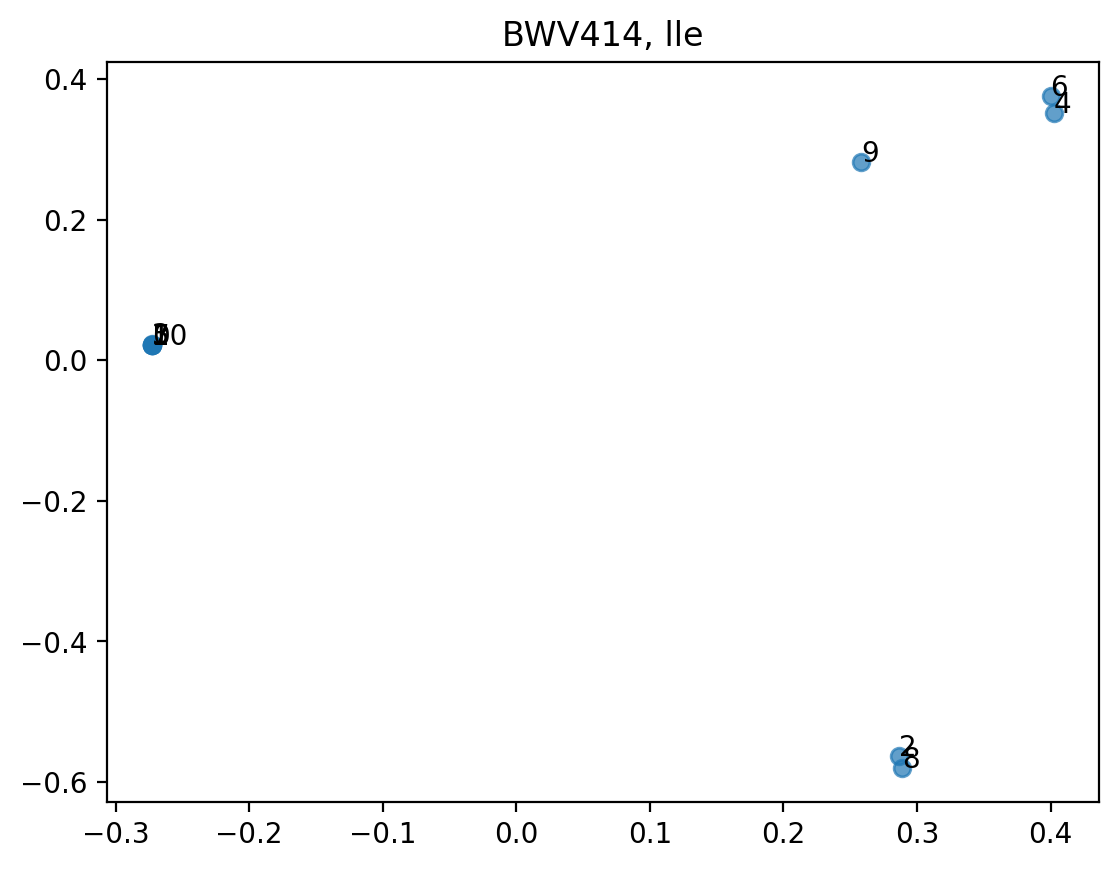

In [ ]:
tivpoints = get_visualization(algorithm, list(tivs.values())[start:start+number_events])
print_visualization_2d(tivpoints, labels, algorithm, major=False, title="BWV414" + f', {algorithm}')

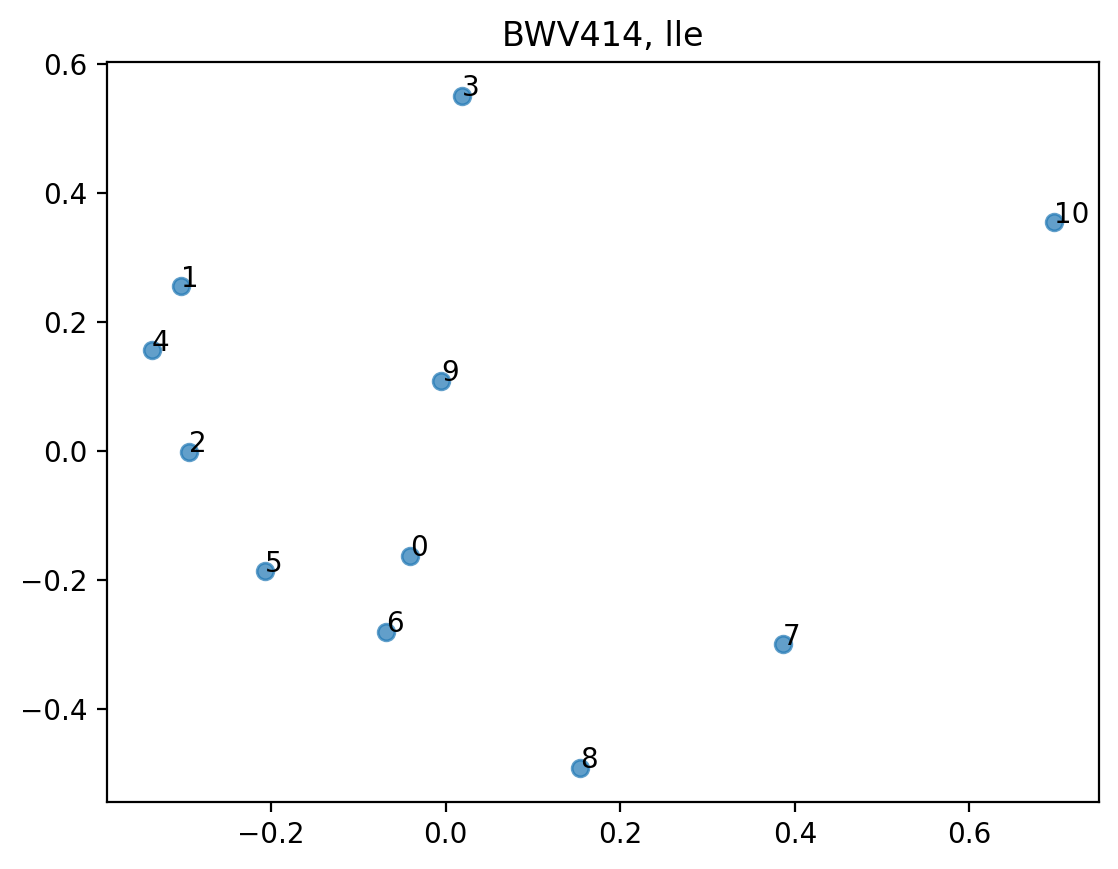

In [ ]:
tiv128points = get_visualization(algorithm, list(tivs_128.values())[start:start+number_events])
print_visualization_2d(get_visualization(algorithm, list(tivs_128.values())[start:start+number_events]), labels, algorithm, major=False, title="BWV414" + f', {algorithm}')

In [ ]:
import pandas as pd
#list(pd.DataFrame(points)[1])
#list(pd.DataFrame(tivpoints)[1])
list(pd.DataFrame(tiv128points)[1])

[-0.16317588814977516,
 0.25474062864080643,
 -0.001352298700932359,
 0.5498010339932327,
 0.1557519149665271,
 -0.18654326002825639,
 -0.2805358100876254,
 -0.3000441981106915,
 -0.49132503244742287,
 0.10891616664730958,
 0.3537667432768245]

In [ ]:
dist_to_1_lt = get_dist_matrix(latent_spaces, 'cosine').loc[start, start:start+number_events]
dist_to_1_lt_euc = get_dist_matrix(latent_spaces, 'euclidean').loc[start, start:start+number_events]

dist_to_1_tiv = get_dist_matrix(tivs, 'cosine').loc[start, start:start+number_events]
dist_to_1_tiv128 = get_dist_matrix(tivs_128, 'cosine').loc[start, start:start+number_events]

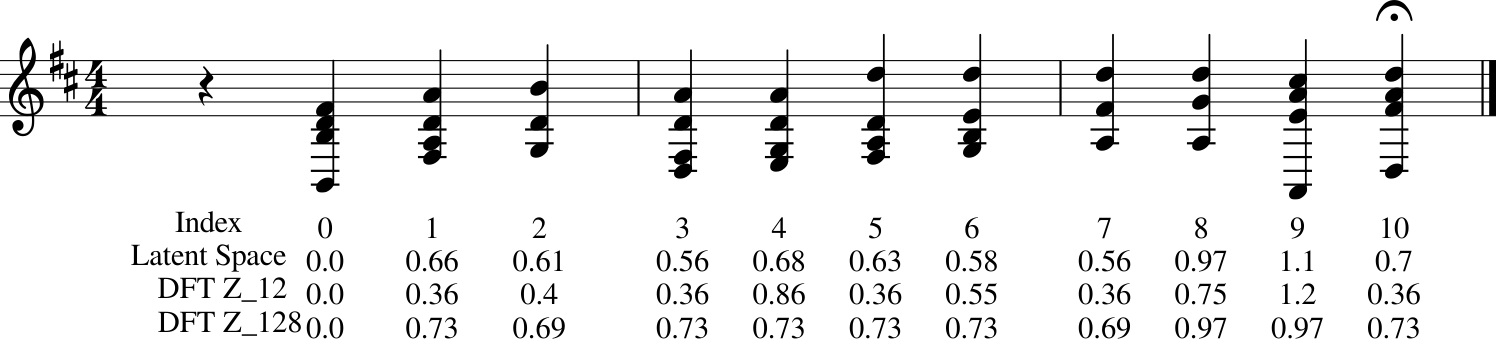

In [ ]:
import copy

part = m21.stream.Stream()

for i, y in enumerate([copy.deepcopy(x[3]) for x in to_visualize[start:start+number_events]]):
  y.offset = i
  y.quarterLength = 1
  y.lyrics = []

  y.insertLyric(f"\n\n{i}", index=0)
  y.insertLyric(f"\n\n{round(dist_to_1_lt.iloc[i],2)}", index=1)
  #y.insertLyric(f"\n\n{round(dist_to_1_lt_euc[i],3)}", index=2)
  y.insertLyric(f"\n\n{round(dist_to_1_tiv.iloc[i],2)}", index=3)
  y.insertLyric(f"\n\n{round(dist_to_1_tiv128.iloc[i],2)}", index=4)

  part.insert(y)

n = m21.note.Rest(1)
part.insertAndShift(0, n)

n.insertLyric("\nIndex", index=0)
n.insertLyric("\nLatent Space", index=1)
#n.insertLyric("\nLS (euc)", index=2)
n.insertLyric("\nDFT Z_12", index=3)
n.insertLyric("\nDFT Z_128", index=4)

#_ = [n.lyc.for lyc in n.lyrics]

part.insert(0, list(chorale_c.recurse().getElementsByClass('KeySignature'))[0])
part.show()

# DFT common tone space
# Tiv 12 reduzir ao espaço de 12 notas
# Embedding space space of voice-leading (acordes 7, 8)
# Ver a ordem dos que partilham 2 notas
# Usar uma chaveta para os que têm as mesmas distâncias
# Porque é que ele aproxima o 8, 6, 1
# Tabela de Transições entre acorde 0,6,1
# View se estão a fazer relacção com coeficientes específicos (periodicidade)

In [ ]:
def get_part_ordered_distances(to_visualize, start, number_events, dist_matrix, space='Z_12'):
  partl = m21.stream.Part()

  chs = [copy.deepcopy(x[3]) for x in to_visualize[start:start+number_events]]
  for i, ev in enumerate(dist_matrix[:-1].astype(float).round(2).sort_values().index): # dist_matrix tolerance

    if space == 'Z_12':
      c = m21.chord.Chord(chs[ev-start].orderedPitchClasses, quarterLength=1)
    else:
      c = m21.chord.Chord(chs[ev-start].pitches, quarterLength=1)

    c.lyrics = []
    c.insertLyric(f"\n\n{ev}", index=0)
    partl.insert(i, c)

  return partl

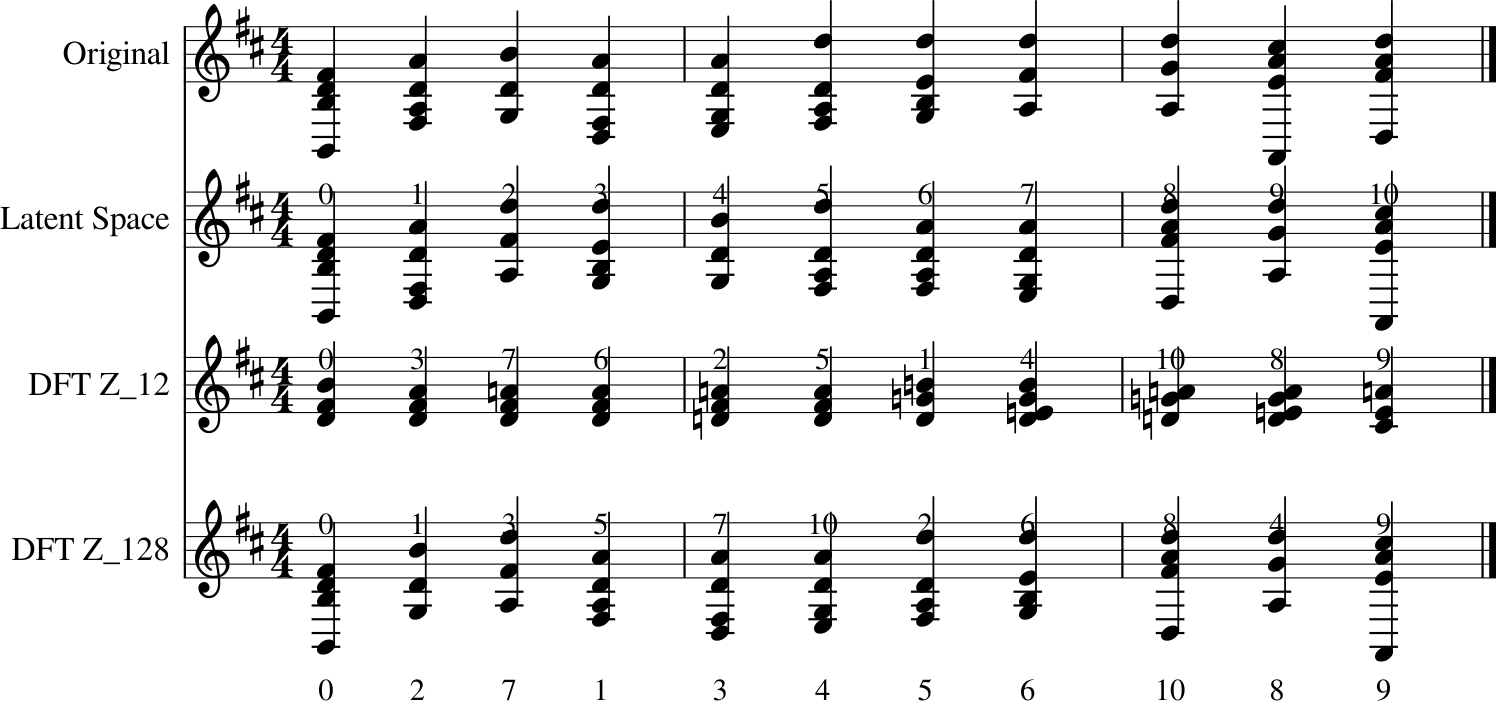

PosixPath('/content/drive/MyDrive/AdapExperiments/music.mxl')

In [ ]:
# 4 part ordered:
# - original
# - lat (cos)
# - tiv
# - tiv 128

part_original = m21.stream.Part()
for i, y in enumerate([copy.deepcopy(x[3]) for x in to_visualize[start:start+number_events]]):
  y.offset = i
  y.quarterLength = 1
  y.lyrics = []
  y.expressions = []
  y.insertLyric(f"\n\n{i}", index=0)
  part_original.insert(y)

part_original.partName = 'Original'
part_original.partAbbreviation = 'Original'
part_original.insert(0, list(chorale_c.recurse().getElementsByClass('KeySignature'))[0])


part_lat = get_part_ordered_distances(to_visualize, start, number_events, dist_to_1_lt, 'LTS')
part_lat.partName = 'Latent Space'
part_lat.insert(0, list(chorale_c.recurse().getElementsByClass('KeySignature'))[0])

part_tiv = get_part_ordered_distances(to_visualize, start, number_events, dist_to_1_tiv)
part_tiv.partName = 'DFT Z_12'
part_tiv.insert(0, list(chorale_c.recurse().getElementsByClass('KeySignature'))[0])

part_tiv128 = get_part_ordered_distances(to_visualize, start, number_events, dist_to_1_tiv128, 'Z_128')
part_tiv128.partName = 'DFT Z_128'
part_tiv128.insert(0, list(chorale_c.recurse().getElementsByClass('KeySignature'))[0])

score = m21.stream.Stream()

score.insert(0, part_original)
score.insert(0, part_lat)
score.insert(0, part_tiv)
score.insert(0, part_tiv128)

score.show()
score.write('mxl', 'music.mxl',)

### Magnitude of Latent Space Vectors


AVG magnitude: 14.315421


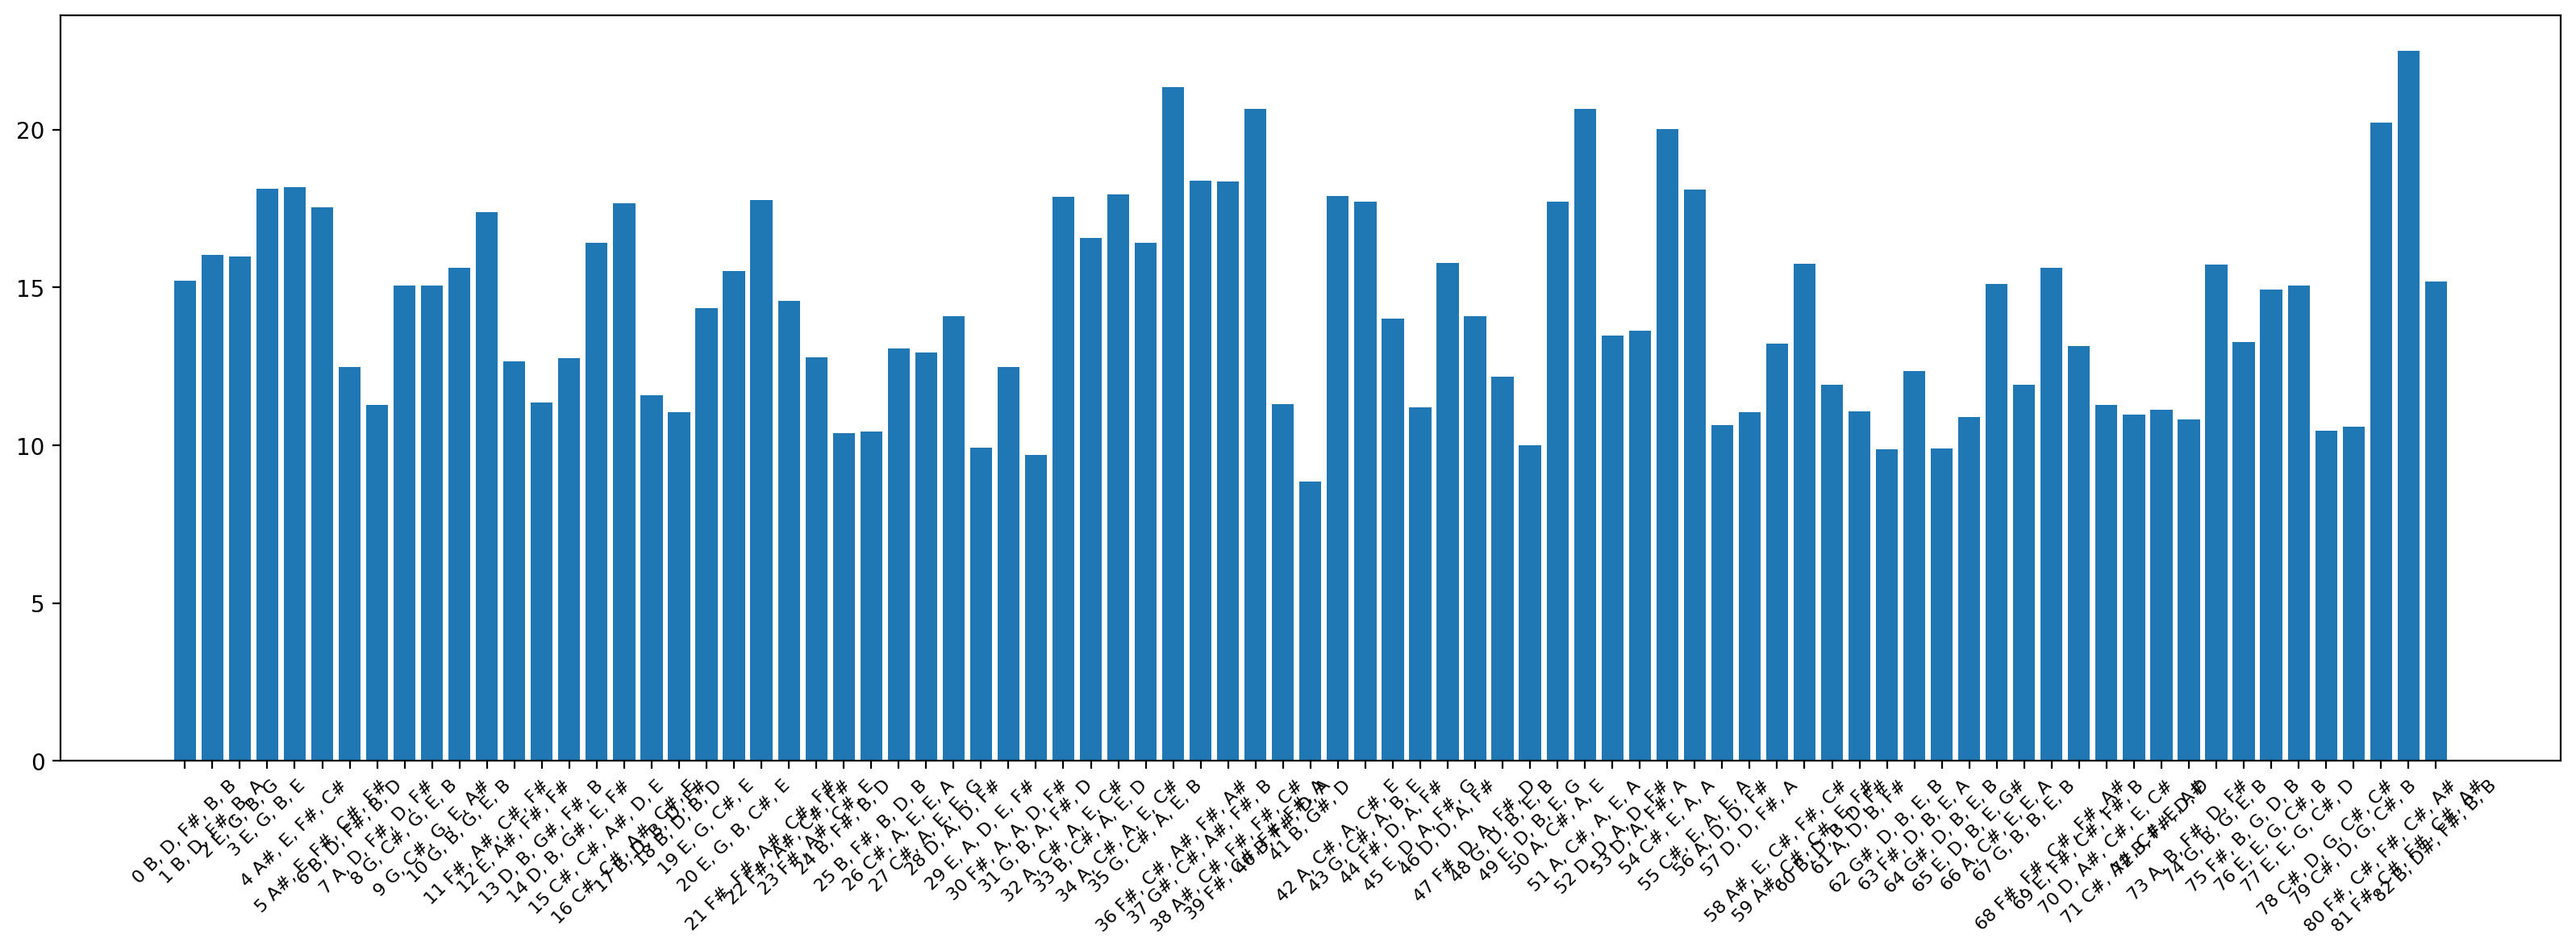

In [ ]:
norms = {i: np.linalg.norm(lat) for i, lat in latent_spaces.items()}

print('AVG magnitude:', np.average(np.asarray(list(norms.values()))))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,6))

ax.bar([f"{i} {', '.join(to_visualize[i][3].pitchNames)}" for i, _ in norms.items()], list(norms.values()))
plt.xticks(rotation=45, fontsize=8)

plt.show()

In [ ]:
norms_lat = {i: np.linalg.norm(lat) for i, lat in latent_spaces.items()}
norms_tiv = {i: np.linalg.norm(tiv) for i, tiv in tivs.items()}
norms_tiv128 = {i: np.linalg.norm(tiv) for i, tiv in tivs_128.items()}

print('* Latent Space vs TIV Magnitude')
print(get_results(list(norms_lat.values()), list(norms_tiv.values())))
print()
print('* Latent Space vs TIV 128 Magnitude')
print(get_results(list(norms_lat.values()), list(norms_tiv128.values())))
print()

* Latent Space vs TIV Magnitude
(-1.7719748856323867, PearsonRResult(statistic=0.1982782772796728, pvalue=0.0723528269535495), SignificanceResult(statistic=0.24306107750525865, pvalue=0.026820048967262512))

* Latent Space vs TIV 128 Magnitude
(-1.142476421066851, PearsonRResult(statistic=0.13583931058562065, pvalue=0.22077438976855318), SignificanceResult(statistic=0.15712462799551477, pvalue=0.15601784278266762))



### Visualization of TIV DFT 12 and 128

In [ ]:
tivs = {'-'.join([str(i) for i in j]): calculate_tiv(j) for j in [[0], [2], [4], [5], [7], [9], [11], [0,2,4,5,7,9,11]]}
tivspoints = get_visualization('lle', list(tivs.values()))

import pandas as pd
pd.DataFrame(tivspoints, index=list(tivs.keys()), columns=["x","y"])

,x,y
0,-2.027231e-01,6.578239e-01
2,4.857226e-16,-9.159340e-16
4,2.027231e-01,-6.578239e-01
5,-6.169099e-01,-2.490354e-01
7,-2.798670e-01,7.244998e-02
9,2.798670e-01,-7.244998e-02
11,6.169099e-01,2.490354e-01
0-2-4-5-7-9-11,-6.938894e-17,-4.579670e-16


In [ ]:
tivs = {'-'.join([str(i) for i in j]): calculate_tiv(j) for j in [[0,4,7], [2,5,9], [4,7,11], [5,9,0], [7,11,2], [9,0,4], [11,2,5], [0,2,4,5,7,9,11]]}
tivspoints = get_visualization('lle', list(tivs.values()))

import pandas as pd
pd.DataFrame(tivspoints, index=list(tivs.keys()), columns=["x","y"])

,x,y
0-4-7,1.813957e-01,0.473337
2-5-9,-4.257767e-01,-0.336418
4-7-11,5.346118e-01,0.136932
5-9-0,-5.346118e-01,0.136932
7-11-2,4.257767e-01,-0.336418
9-0-4,-1.813957e-01,0.473337
11-2-5,1.421085e-14,-0.536587
0-2-4-5-7-9-11,-1.110223e-16,-0.011114


In [ ]:
tonalities = {
    'CMaj': [0,2,4,5,7,9,11],
    'Cmin': [0,2,3,5,7,8,10]
}
for tonal in range(1,12):
  note = m21.note.Note(tonal)
  tonalities[note.name+'Maj'] = [(i+tonal)%12 for i in tonalities['CMaj']]
  tonalities[note.name+'min'] = [(i+tonal)%12 for i in tonalities['Cmin']]

tivs = {key: calculate_tiv(pcp) for key, pcp in tonalities.items()}
tivspoints = get_visualization('lle', list(tivs.values()))

import pandas as pd
po = pd.DataFrame(tivspoints, index=list(tivs.keys()), columns=["x", "y" ])
po['key'] = [x[:-3] for x in tivs.keys()]
po['mode'] = [x[-3:] for x in tivs.keys()]

po

,x,y,key,mode
CMaj,0.287564,-0.022983,C,Maj
Cmin,0.023014,0.287951,C,min
C#Maj,-0.237546,0.163686,C#,Maj
C#min,-0.163686,-0.237546,C#,min
DMaj,0.124045,-0.260880,D,Maj
Dmin,0.260529,0.123878,D,min
E-Maj,0.022983,0.287564,E-,Maj
E-min,-0.287564,0.022983,E-,min
EMaj,-0.163907,-0.237866,E,Maj
Emin,0.237866,-0.163907,E,min


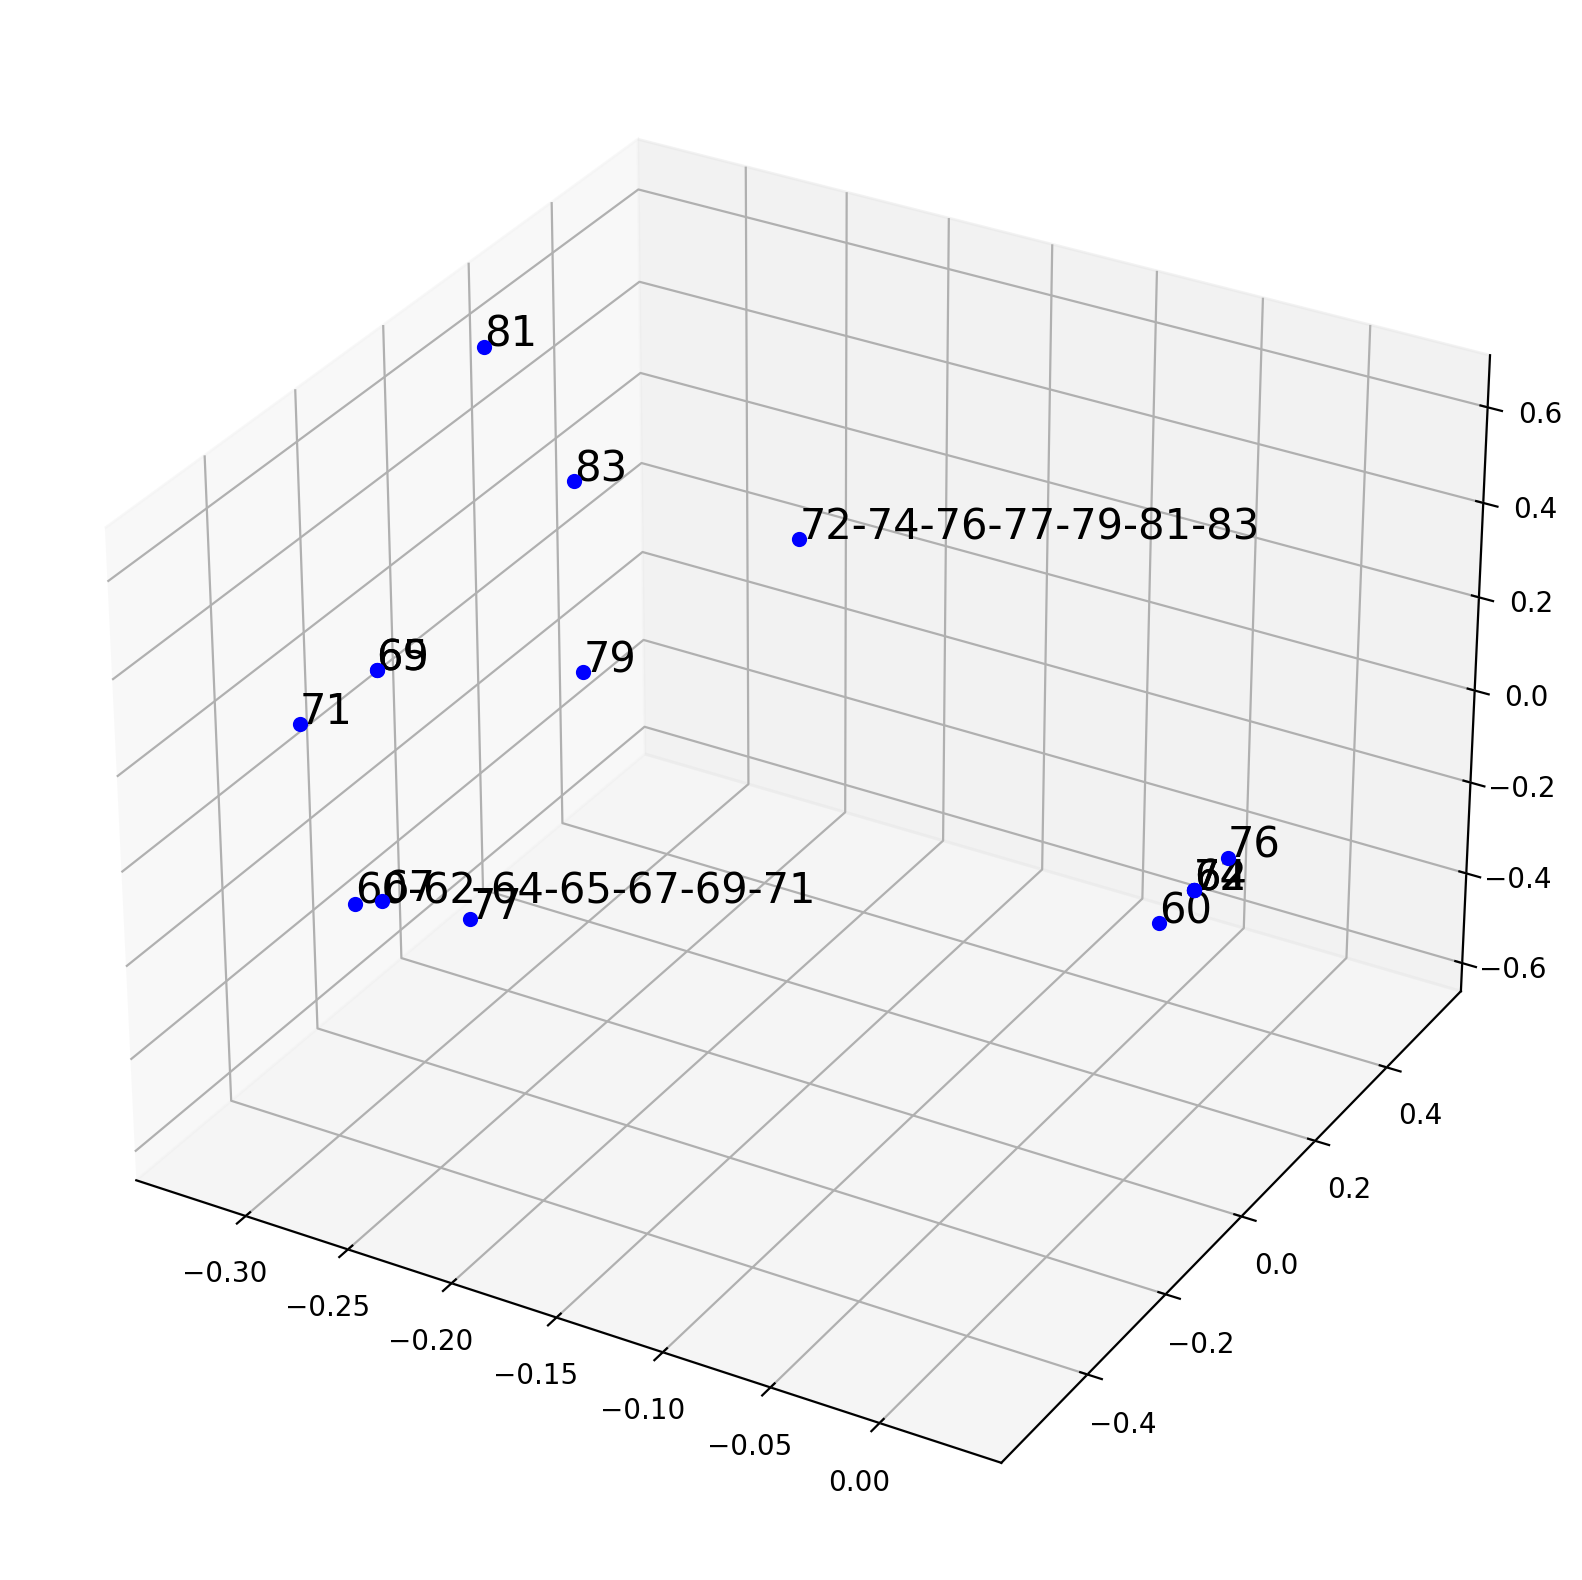

In [ ]:
points = [[0], [2], [4], [5], [7], [9], [11], [0,2,4,5,7,9,11]]
chords = [create_chord_from_pitch_classes(p, fr_size=1) for p in points] + [create_chord_from_pitch_classes(p, fr_size=1, start=72) for p in points]
tivs128 = {'-'.join([str(i) for i in np.where(j == 1.)[1]]): dft_easy_encoding(j).numpy()[0] for j in chords}

tivs128points = get_visualization('lle', list(tivs128.values()), 3)

import pandas as pd
oct = pd.DataFrame(tivs128points, index=list(tivs128.keys()), columns=["x","y", "z"])

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from numpy.random import rand
from IPython.display import HTML
from matplotlib import animation


fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

for i in range(len(oct.index)): # plot each point + it's index as text above
  ax.scatter(oct.iloc[i, 0], oct.iloc[i, 1], oct.iloc[i, 2], color='b')
  ax.text(oct.iloc[i, 0], oct.iloc[i, 1], oct.iloc[i, 2], '%s' % (oct.index[i]), size=15, zorder=1, color='k')

plt.show()

                             x         y         z label octave
60-64-67             -0.143168  0.293323  0.112614     I      k
62-65-69              0.246403  0.308816 -0.320404    ii      k
64-67-71             -0.283714  0.333469  0.242811   iii      k
65-69-72              0.314626  0.196768 -0.342806    IV      k
67-71-74             -0.334131  0.190088  0.191808     V      k
69-72-76              0.319313  0.038971 -0.225137    vi      k
71-74-77             -0.348504 -0.029061  0.034748  viiº      k
60-62-64-65-67-69-71 -0.015884  0.436641 -0.026354    CM      k
72-76-79              0.268955 -0.121190  0.001961     I      g
74-77-81             -0.280104 -0.238743 -0.133124    ii      g
76-79-83              0.240862 -0.225862  0.260526   iii      g
77-81-84             -0.251598 -0.370769 -0.326531    IV      g
79-83-86              0.242692 -0.221075  0.423828     V      g
81-84-88             -0.181956 -0.283041 -0.313221    vi      g
83-86-89              0.199576 -0.116530

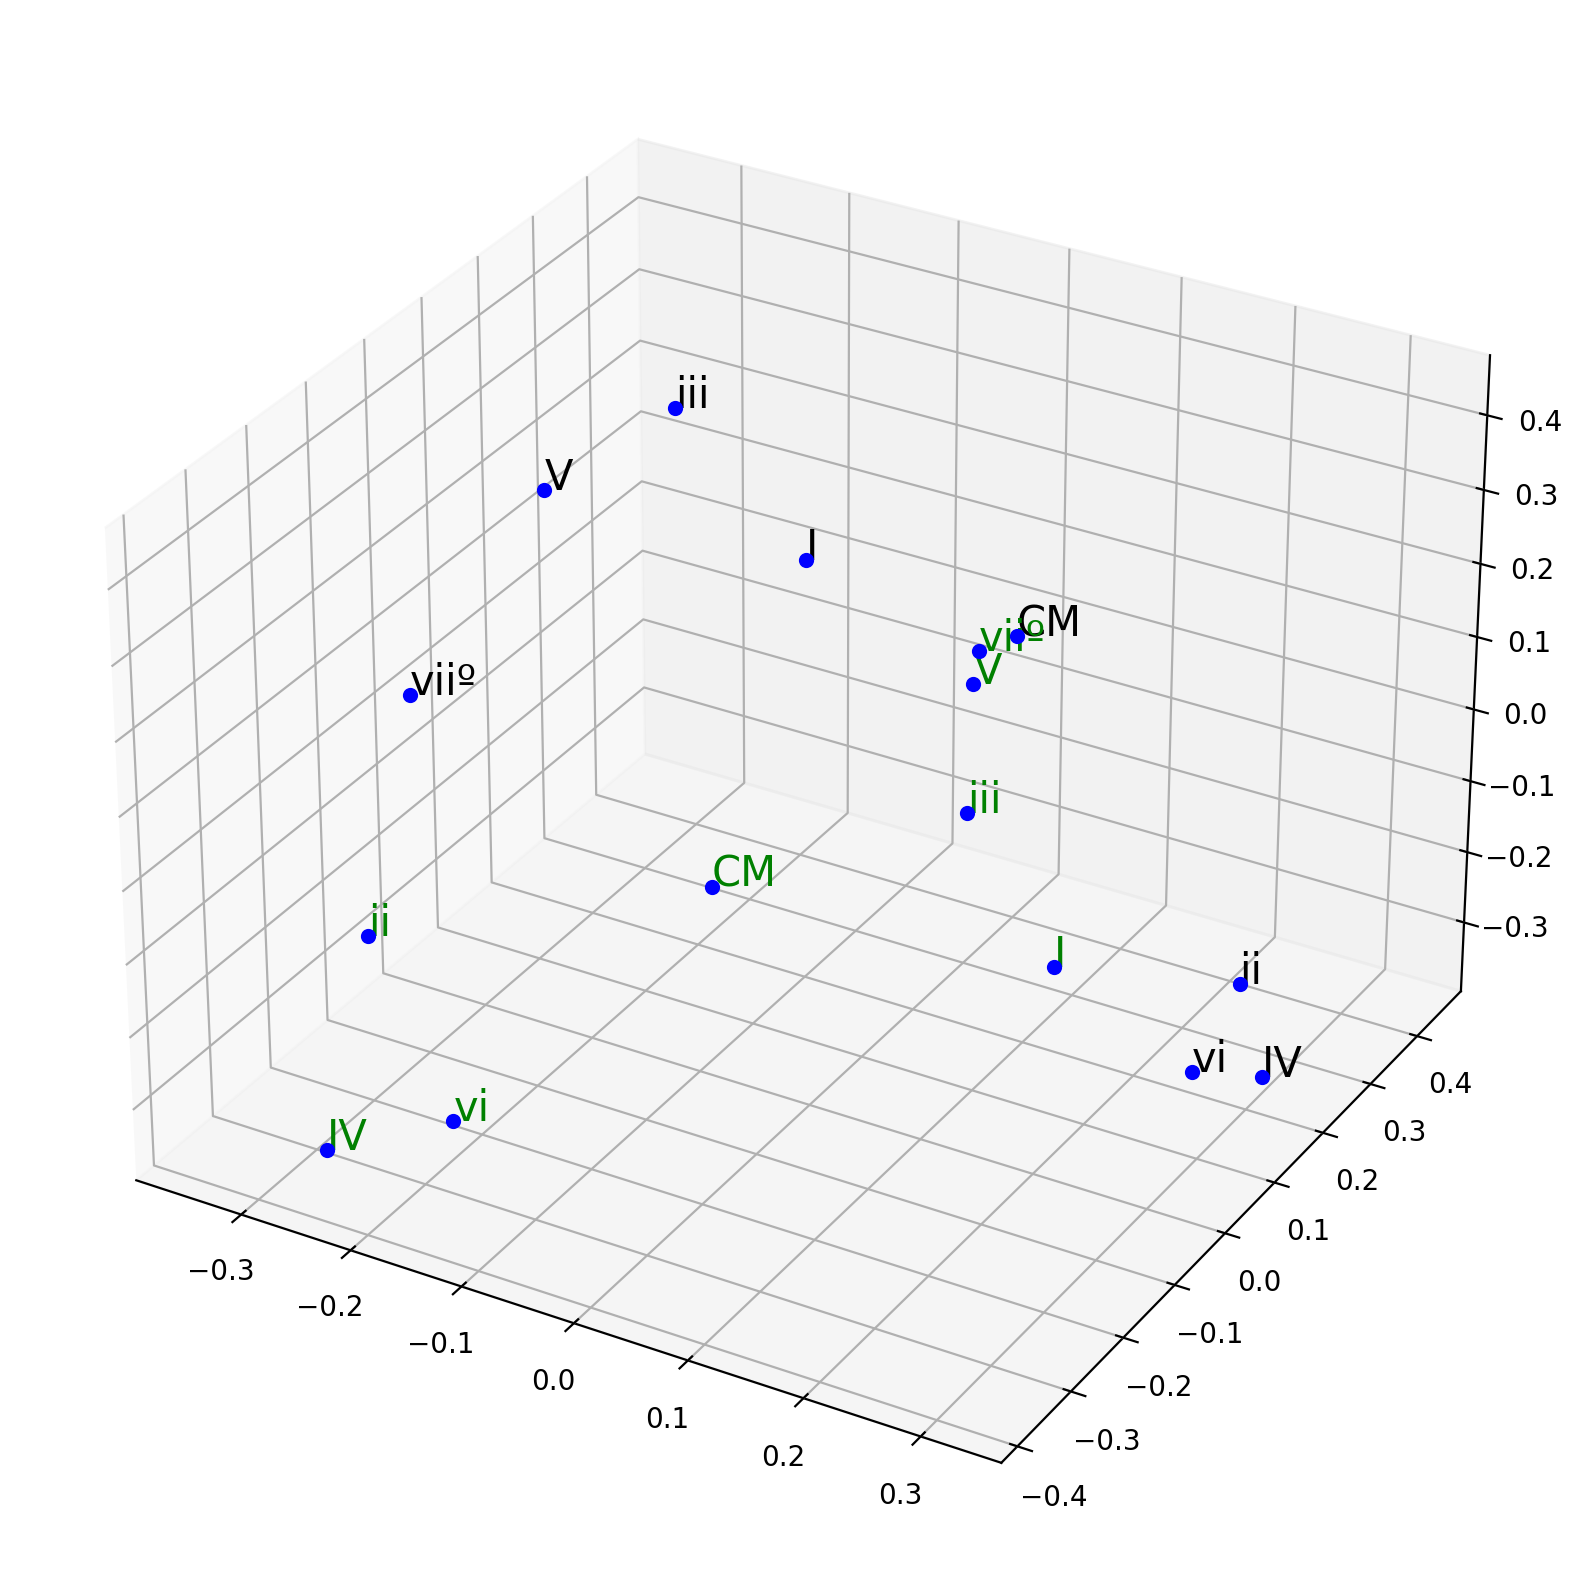

In [ ]:
points = [[0,4,7], [2,5,9], [4,7,11], [5,9,12], [7,11,14], [9,12,16], [11,14,17], [0,2,4,5,7,9,11]]
chords = [create_chord_from_pitch_classes(p, fr_size=1, start=60) for p in points] + [create_chord_from_pitch_classes(p, fr_size=1, start=72) for p in points]
tivs128 = {'-'.join([str(i) for i in np.where(j == 1.)[1]]): dft_easy_encoding(j).numpy()[0] for j in chords}

tivs128points = get_visualization('lle', list(tivs128.values()), 3)

import pandas as pd
oct = pd.DataFrame(tivs128points, index=list(tivs128.keys()), columns=["x","y","z"])
oct['label'] = ['I', 'ii', 'iii', 'IV', 'V', 'vi', 'viiº', 'CM'] * 2
oct['octave'] = ['k'] * 8 + ['g'] * 8

print(oct)

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from numpy.random import rand
from IPython.display import HTML
from matplotlib import animation

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

for i in range(len(oct.index)): # plot each point + it's index as text above
  ax.scatter(oct.iloc[i, 0], oct.iloc[i, 1], oct.iloc[i, 2], color='b')
  ax.text(oct.iloc[i, 0], oct.iloc[i, 1], oct.iloc[i, 2], '%s' % (oct.iloc[i, 3]), size=15, zorder=1, color=oct.iloc[i, 4])

plt.show()


In [ ]:
points = [[0,4,7], [2,5,9], [4,7,11], [5,9,12], [7,11,14], [9,12,16], [11,14,17], [0,2,4,5,7,9,11]]
ipoints = [[12,4,7], [14,5,9], [16,7,11], [17,9,12], [19,11,14], [21,12,16], [23,14,17], [0,2,4,5,7,9,11]]
#i2points = [[12,16,7], [14,17,9], [16,19,11], [17,21,12], [19,23,14], [21,24,16], [23,26,17], [0,2,4,5,7,9,11]]

chords = [create_chord_from_pitch_classes(p, fr_size=1) for p in points] + [create_chord_from_pitch_classes(p, fr_size=1) for p in ipoints] #+ [create_chord_from_pitch_classes(p, fr_size=1) for p in i2points]
labels = points + ipoints #+ i2points

tivs128 = {'-'.join([str(k) for k in labels[i]]): dft_easy_encoding(j).numpy()[0] for i, j in enumerate(chords)}

tivs128points = get_visualization('lle', list(tivs128.values()), 2)
"""
import pandas as pd
oct = pd.DataFrame(tivs128points, index=list(tivs128.keys()), columns=["x","y", "z"])

oct['label'] = ['I', 'ii', 'iii', 'IV', 'V', 'vi', 'viiº', 'CM'] + ['I', 'ii', 'iii', 'IV', 'V', 'vi', 'viiº'] * 2
oct['octave'] = ['k'] * 8 + ['g'] * 7 + ['r'] * 7

print(oct)

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from numpy.random import rand
from IPython.display import HTML
from matplotlib import animation

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

for i in range(len(oct.index)): # plot each point + it's index as text above
  ax.scatter(oct.iloc[i, 0], oct.iloc[i, 1], oct.iloc[i, 2], color='b')
  ax.text(oct.iloc[i, 0], oct.iloc[i, 1], oct.iloc[i, 2], '%s' % (oct.iloc[i, 3]), size=15, zorder=1, color=oct.iloc[i, 4])

plt.show()
"""
pd.DataFrame(tivs128points, index=list(tivs128.keys()), columns=["x","y"])

,x,y
0-4-7,-0.372577,0.261713
2-5-9,-0.032391,-0.168610
4-7-11,-0.232003,0.312760
5-9-12,0.009811,-0.365949
7-11-14,0.157515,0.274794
9-12-16,-0.061160,-0.430405
11-14-17,0.438923,0.225358
0-2-4-5-7-9-11,-0.299006,0.132195
12-4-7,-0.359219,0.156467
14-5-9,0.160355,-0.091464


In [ ]:
tonalities = {
    'CMaj': [0,2,4,5,7,9,11],
    'Cmin': [0,2,3,5,7,8,10]
}
for tonal in range(1,12):
  note = m21.note.Note(tonal)
  tonalities[note.name+'Maj'] = sorted([(i+tonal)%12 for i in tonalities['CMaj']])
  tonalities[note.name+'min'] = sorted([(i+tonal)%12 for i in tonalities['Cmin']])

tivs = {key: dft_easy_encoding(create_chord_from_pitch_classes(pcp, fr_size=1, start=list(range(0,127,12)))).numpy()[0] for key, pcp in tonalities.items()}
tivspoints = get_visualization('lle', list(tivs.values()))

import pandas as pd
po = pd.DataFrame(tivspoints, index=list(tivs.keys()), columns=["x", "y" ])
po['key'] = [x[:-3] for x in tivs.keys()]
po['mode'] = [x[-3:] for x in tivs.keys()]

po

,x,y,key,mode
CMaj,-0.208483,0.201258,C,Maj
Cmin,-0.208671,-0.201455,C,min
C#Maj,0.077798,-0.279582,C#,Maj
C#min,0.279480,0.069429,C#,min
DMaj,0.077868,0.279851,D,Maj
Dmin,-0.275940,0.080584,D,min
E-Maj,-0.208483,-0.201258,E-,Maj
E-min,0.201632,-0.206358,E-,min
EMaj,0.279735,0.069497,E,Maj
Emin,-0.074622,0.278264,E,min


## View Transition Matrix

In [ ]:
all_chords = []

start = 1
end = 371
for i, chorale in enumerate(tqdm.tqdm(m21.corpus.chorales.Iterator(start, end, returnType='stream'))):

  chords_c = []
  chorale_c = chorale.chordify(addTies=False)
  for j, chord in enumerate(sorted(list(chorale_c.recurse(classFilter='Chord')), key=lambda x: x.offset)):
      chords_c.append(create_chord_from_pitches([p.midi for p in chord.pitches], fr_size=1))

  all_chords.extend(chords_c)
  for k in range(1, 12):
    all_chords.extend(list(np.roll(np.asarray(chords_c), k)))
    all_chords.extend(list(np.roll(np.asarray(chords_c),-k)))


In [ ]:
chords_n_ext = ['-'.join(str(x) for x in sorted(np.nonzero(a[0])[0])) for a in all_chords]

In [ ]:
import pandas as pd

list_unique = list(set(chords_n_ext))
matrix = np.zeros((len(list_unique), len(list_unique)))

for c1, c2 in tqdm.tqdm(zip(chords_n_ext[:-1], chords_n_ext[1:])):
  matrix[list_unique.index(c1), list_unique.index(c2)] += 1

matrix

In [ ]:
matrix = np.load('transition_matrix.npy', allow_pickle=True, mmap_mode='r')

In [ ]:
with open('list_unique.npy', 'rb') as f:
    list_unique = np.load(f, allow_pickle=True)

In [ ]:
chords = ['-'.join([str(int(cp.ps)) for cp in c[3].pitches]) for c in to_visualize[start:start+number_events]]
chords_in_list = [np.where(list_unique == c)[0][0] for c in chords]

In [ ]:
chords_in_list

[50925,
 37550,
 16500,
 5372,
 51697,
 51853,
 1307,
 26400,
 49535,
 23980,
 32095,
 52931,
 14923,
 23775,
 13051]

In [ ]:
print({i+1: matrix[chords_in_list[0], cl] for i, cl in enumerate(chords_in_list[1:])})

{1: 1.0, 2: 10.0, 3: 2.0, 4: 0.0, 5: 6.0, 6: 14.0, 7: 1.0, 8: 11.0, 9: 0.0, 10: 2.0, 11: 0.0, 12: 0.0, 13: 7.0, 14: 2.0}
